In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../utils/")
sys.path.append("../")

In [3]:
import metrics
from agg_crossfit_results import *

In [4]:
pd.set_option('display.max_rows', 500)


In [8]:
set_name = 'shuffled_published_temporal_set'
metrics_type = 'auc'

In [9]:
model_mapping = {
    'BART-Single': 1,
    'BART-Adapter-Single': 2,
    'BART-BiHNet-Single': 3,
    'BART-Adapter-Vanilla':4, 
    'BART-BiHNet+Vanilla':5,
    'BART-BiHNet+Reg':6,
    'BART-BiHNet+EWC':7,
    'BART-Adapter-Multitask':8,
    'BART-BiHNet-Multitask':9}

# Few shot

In [41]:
set_name= "published_temporal_set"

In [42]:
dir_dict = {"BART-BiHNet+Reg":f"../runs/BiHNet_Reg_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+EWC":f"../runs/BiHNet_ewc_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-Adapter-Multitask": f"../runs/adpter_mtl_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet-Multitask": f"../runs/mtl_hnet_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-Adapter-Vanilla": f"../runs/adapter_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+Vanilla": f"../runs/BiHNet_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
#             "BART-Single": f"../runs/single_{set_name}_fs_0.01_s64_d256_limit/1e-4/0/",
#             "BART-Adapter-Single": f"../runs/adapter_single_{set_name}_fs_0.01_s64_d256_limit/1e-4/0/",
#             "BART-BiHNet-Single": f"../runs/BiHNet_single_{set_name}_fs_0.01_s64_d256_limit/1e-4/0/",
           }

### Fewshot Downstream during Upstream

In [61]:
def get_fs_progress_df(dir_dict, metrics_type):
    dfs = []
    for alg in dir_dict:
        print(alg)
        for with_dash in [True, False]:
            for i in range(26):
                df =  make_few_shot_result_table(dir_dict[alg], postfix=f"_naive_16shot_task_{i}", metrics_type=metrics_type, with_dash=with_dash)
                if df.empty:
                    print("df", df)
                    print(alg, with_dash, "hereeee")
                    continue
                if "task_detail" in df.columns:
                    df = pd.DataFrame(df.groupby(["task_name", "task_detail"])[metrics_type].max()).reset_index()
                else:
                    df = pd.DataFrame(df.groupby(["task_name"])[metrics_type].max()).reset_index()
                df["alg"] = alg
                df["up_task"] = i
                dfs.append(df)
    all_fs_df = pd.concat(dfs)
    all_fs_df = all_fs_df[[metrics_type, "task_name", "task_detail",  "alg", "up_task"]]
    all_fs_df = all_fs_df.rename(columns={metrics_type: f'few-shot-{metrics_type}', 
                                                      'alg': 'model', 
                                                      'task_name': 'dataset', 
                                                      'task_detail': 'task'})
    return all_fs_df

In [62]:
fs_on_upstream_df = get_fs_progress_df(dir_dict, metrics_type='auc')

BART-BiHNet+Reg
df Empty DataFrame
Columns: []
Index: []
BART-BiHNet+Reg True hereeee
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_0.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_1.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_2.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_3.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_4.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_5.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_6.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_7.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_8.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot_task_9.csv
results_task_(\d+)_(\w+)_task_(\d+)_step_([\

In [63]:
fs_on_upstream_df.fillna("-", inplace=True)

In [64]:
avg_fs = fs_on_upstream_df.groupby(['up_task', 'model'])['few-shot-auc'].mean().reset_index()


In [50]:
fs_on_upstream_df.columns

Index(['few-shot-auc', 'dataset', 'task', 'model', 'up_task'], dtype='object')

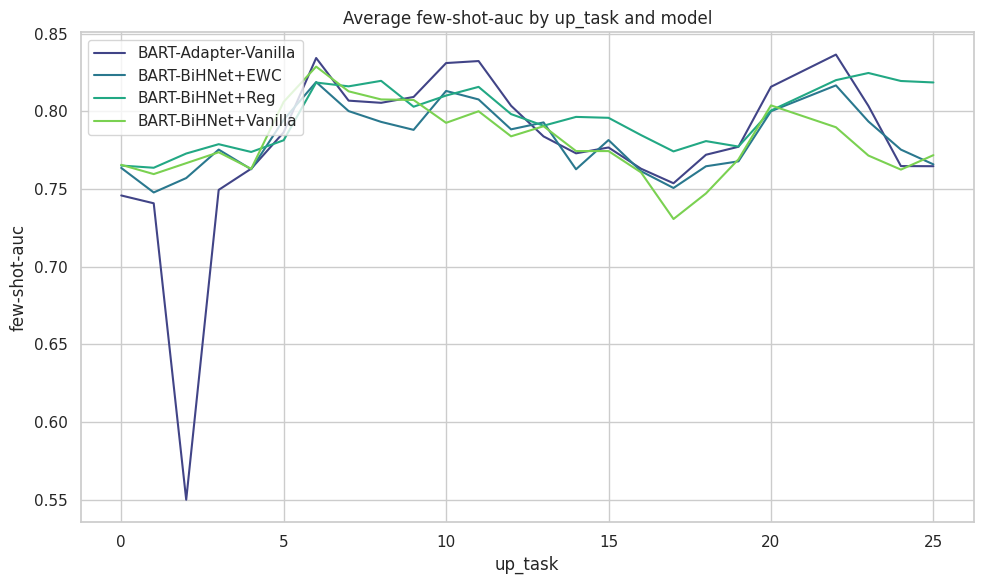

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'result' contains the DataFrame with the aggregated data
# Replace 'result' with the actual name of your DataFrame if it's different

# Create a line plot with Seaborn
sns.set(style="whitegrid")  # Optional: Set a style for the plot

plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Use Seaborn's lineplot function to create the plot
sns.lineplot(data=avg_fs, x='up_task', y='few-shot-auc', hue='model', palette='viridis')

# Optional: Customize the plot further (e.g., labels, title, etc.)
plt.xlabel('up_task')
plt.ylabel('few-shot-auc')
plt.title('Average few-shot-auc by up_task and model')

# Show the plot
plt.legend(loc='upper left')  # Optional: Display the legend
plt.tight_layout()  # Optional: Adjust plot layout
plt.savefig('line_plot.png')
plt.show()

<Figure size 640x480 with 0 Axes>

/mnt/bosco_ud/omrani/clenv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


ValueError: Automatic legend placement (loc='best') not implemented for figure legend

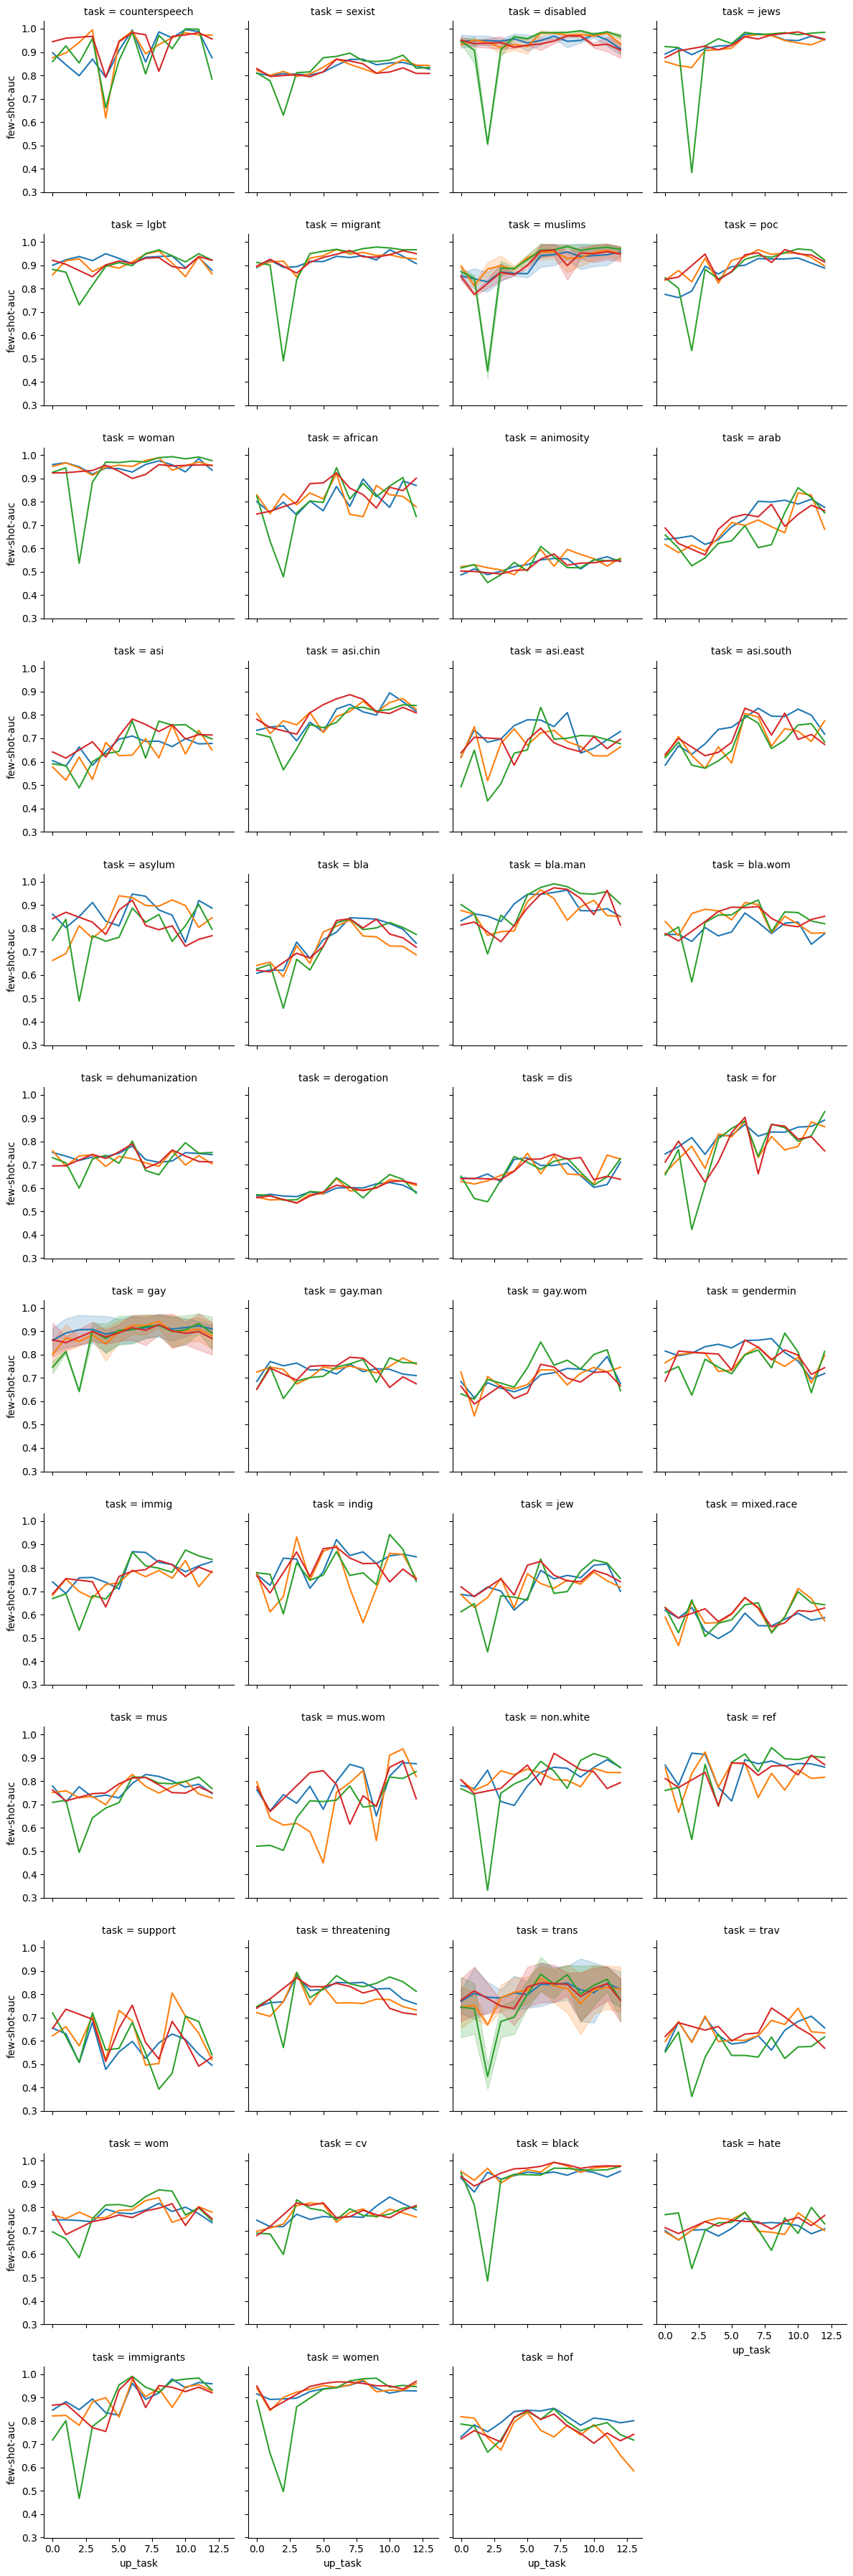

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a FacetGrid for each task
g = sns.FacetGrid(data=fs_on_upstream_df.dropna(), col="task", col_wrap=4)  # You can adjust col_wrap as needed
g.map(sns.lineplot, "up_task", "few-shot-auc", "model")
g.set_axis_labels("up_task", "few-shot-auc")
g.add_legend(title="Model", loc='best')  # Use 'best' to place the legend in the best location
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Line Plots for Different Tasks")
plt.show()

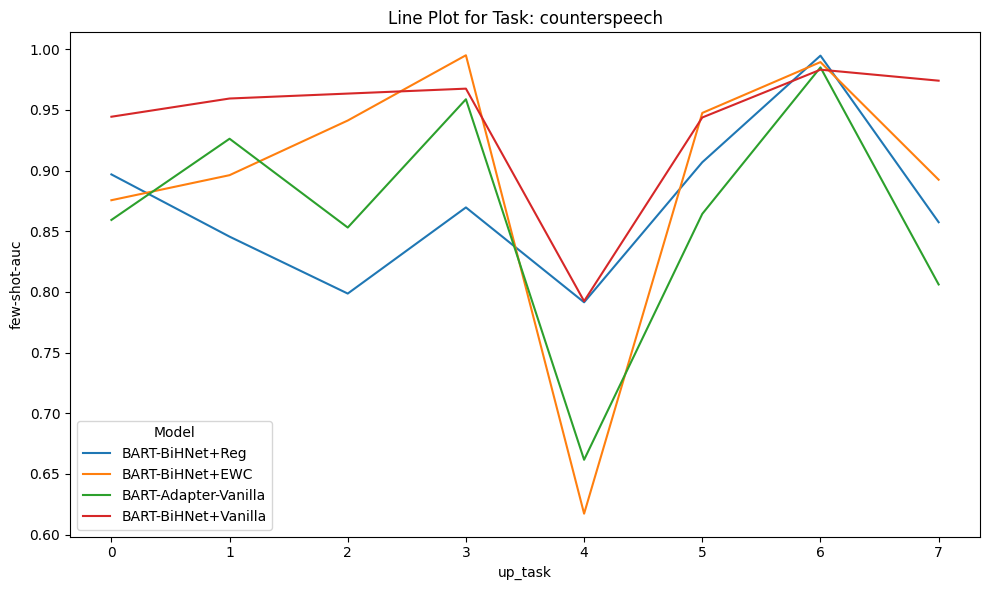

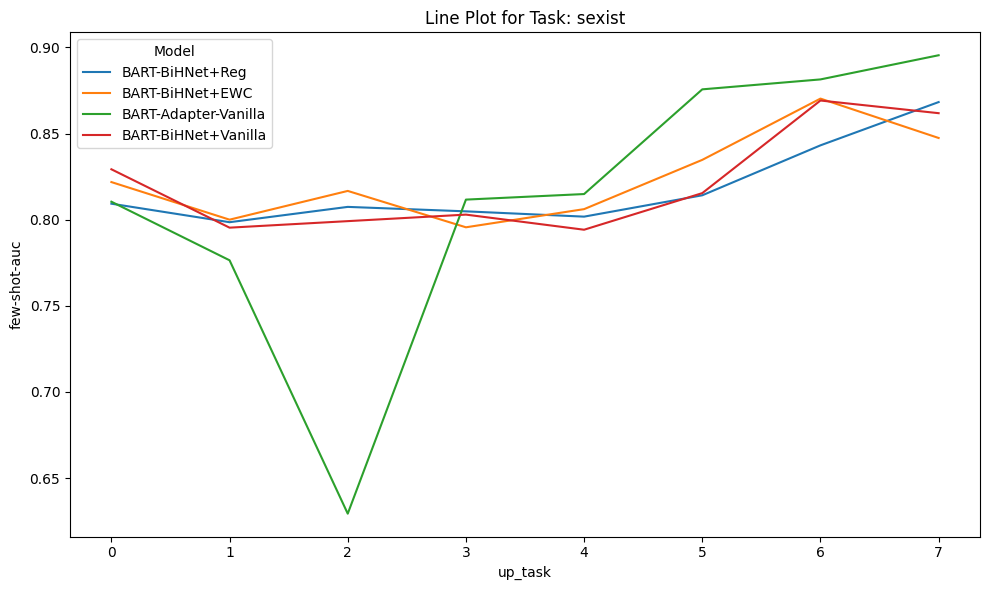

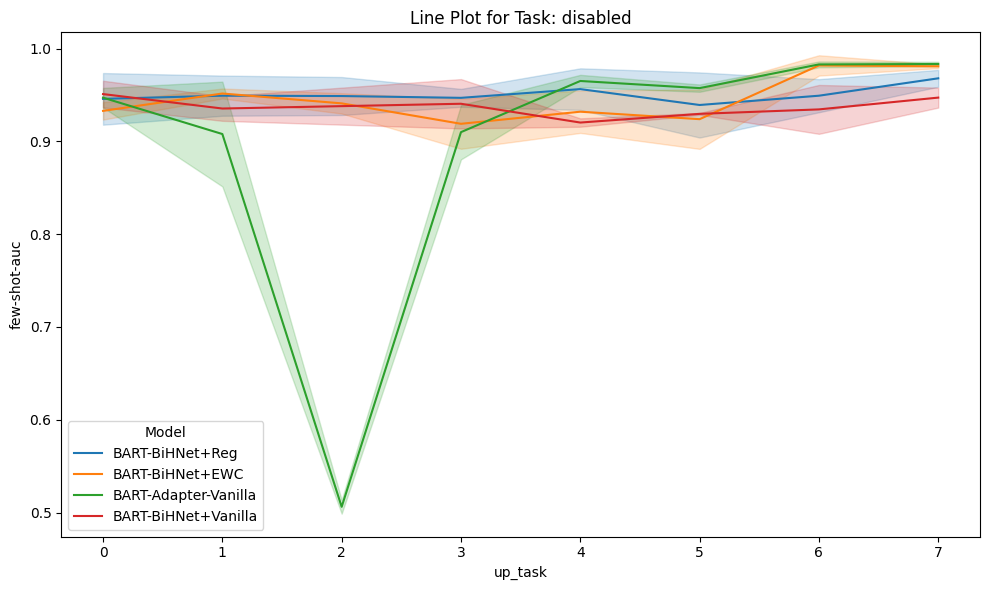

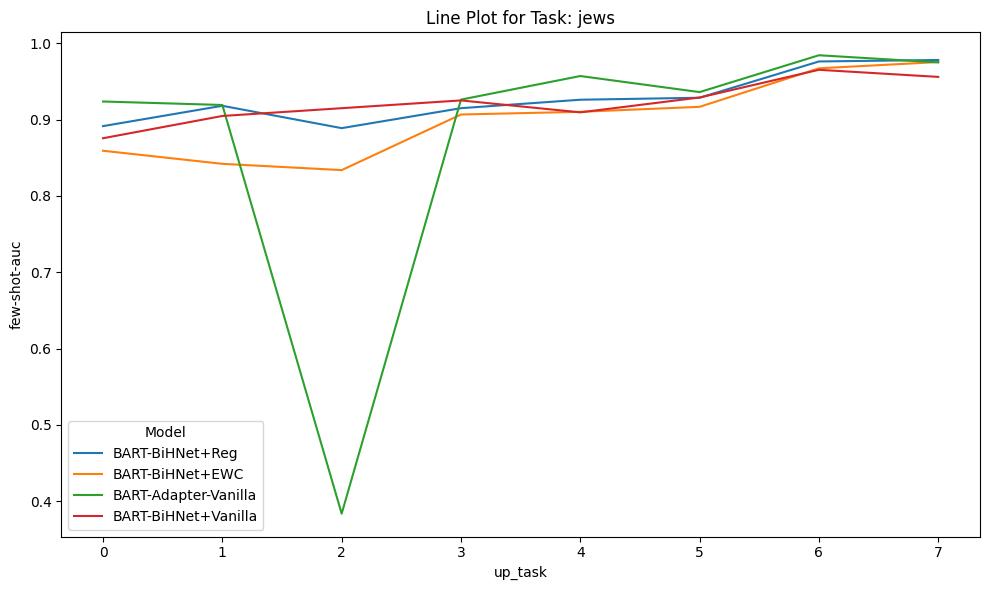

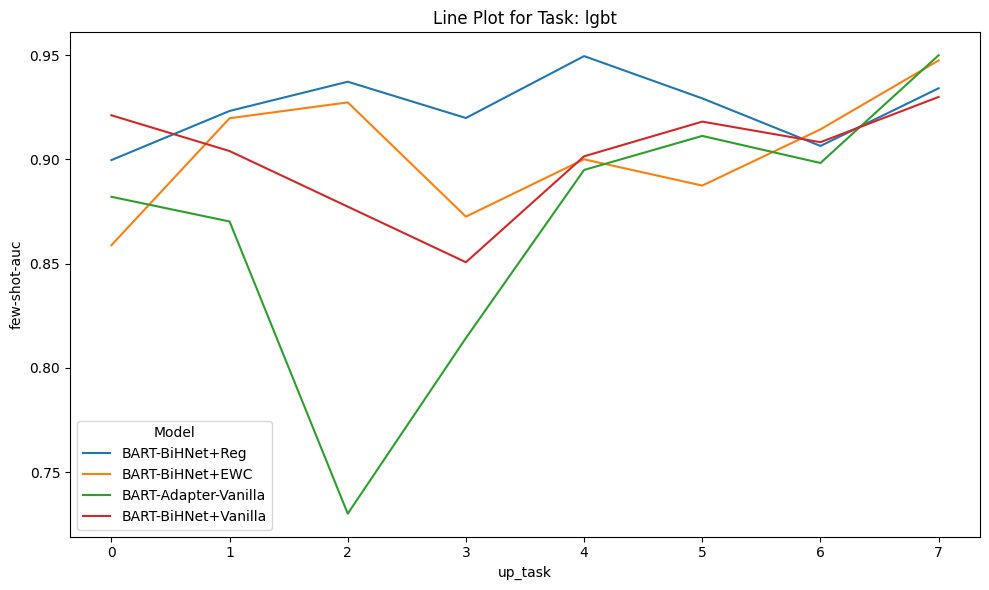

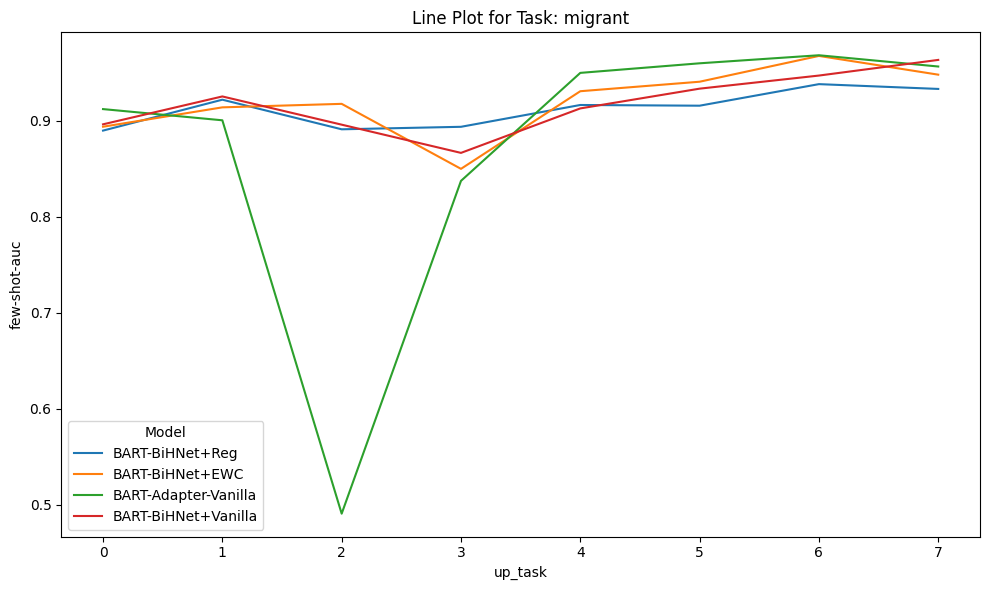

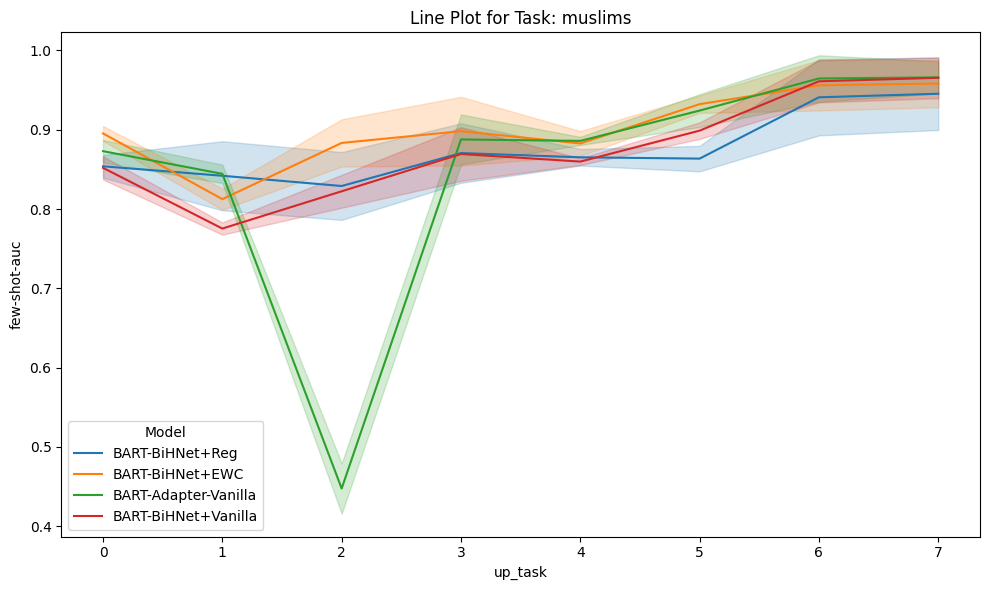

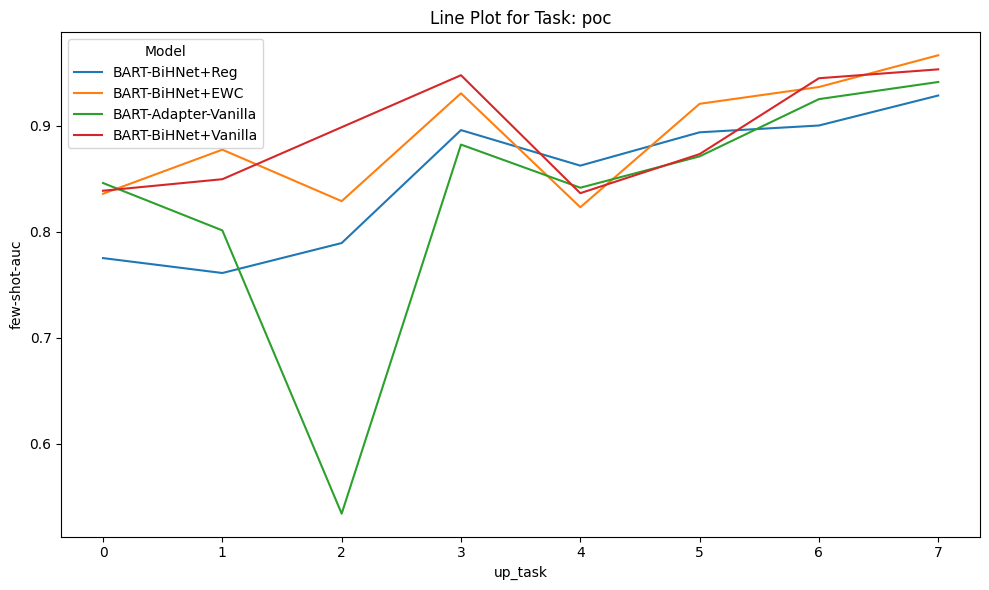

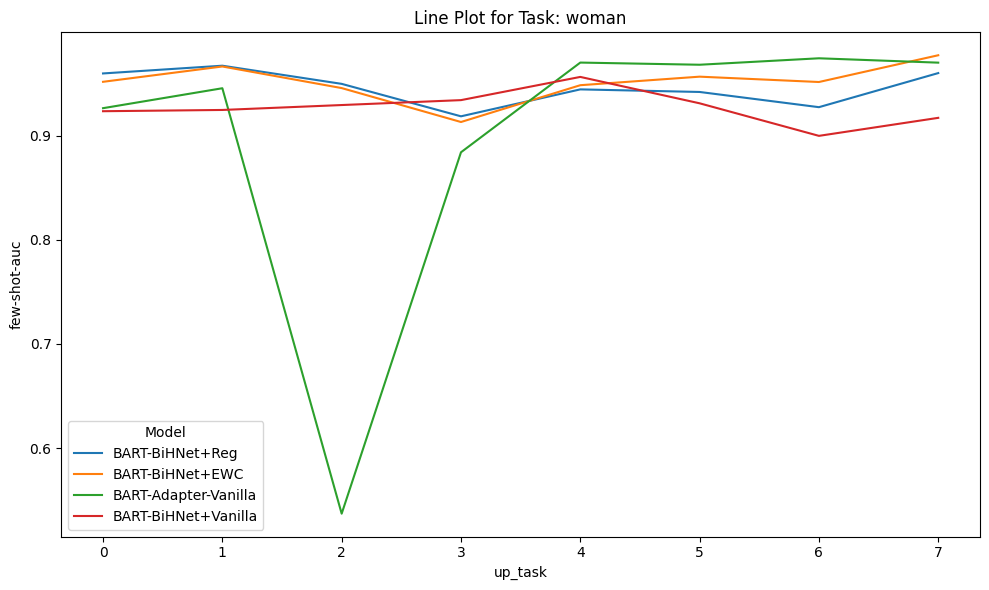

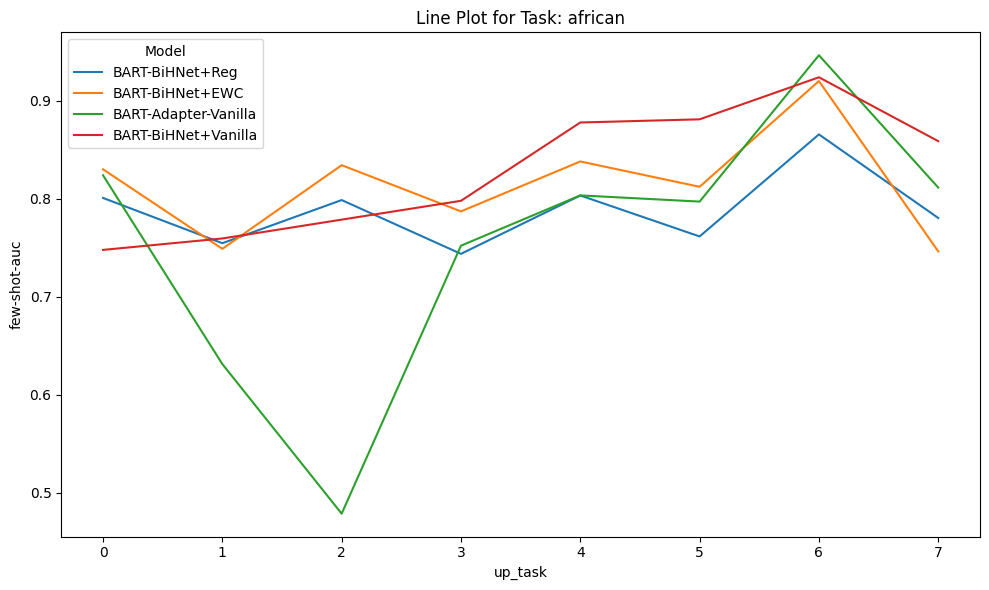

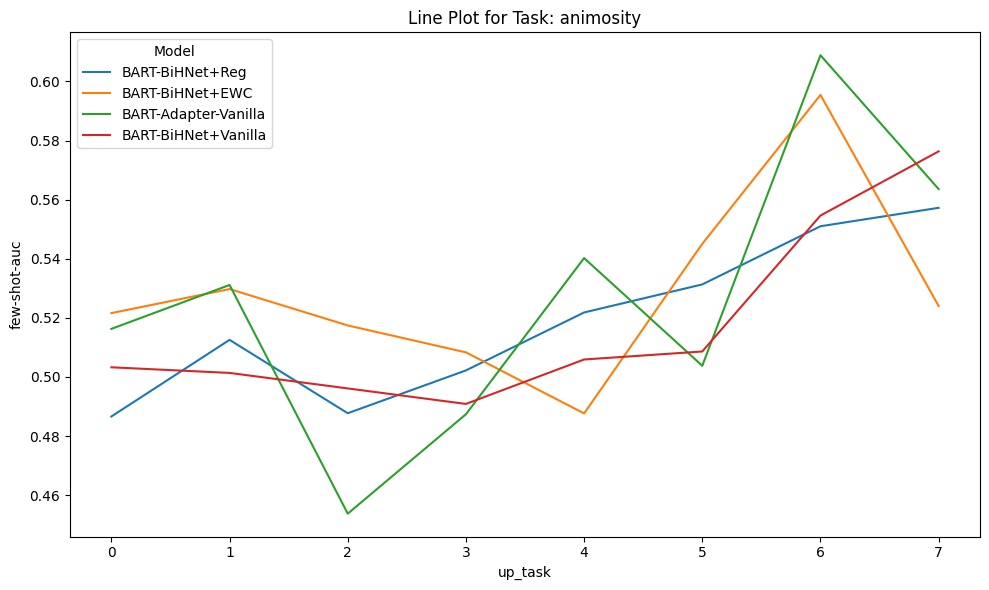

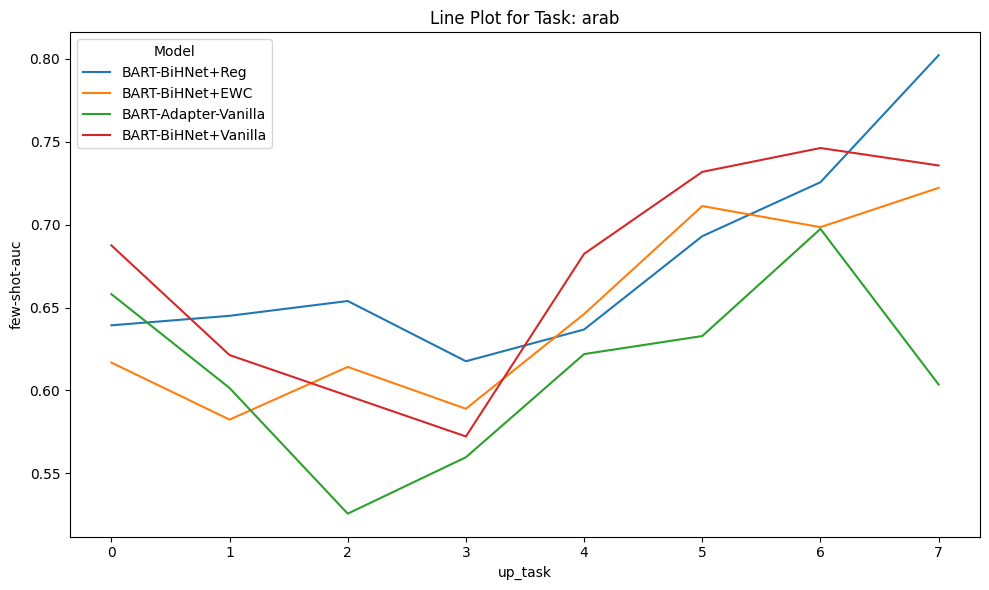

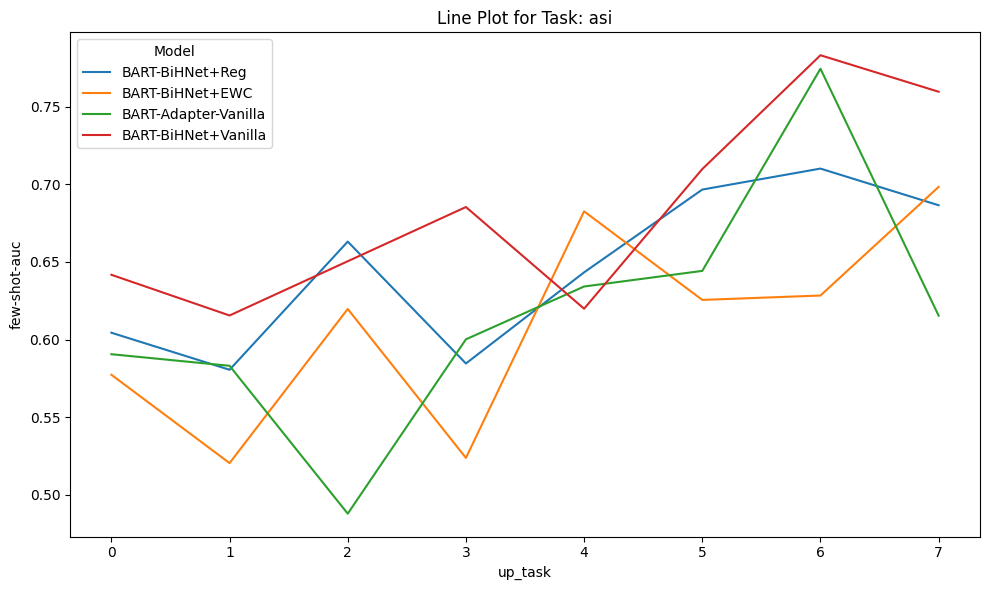

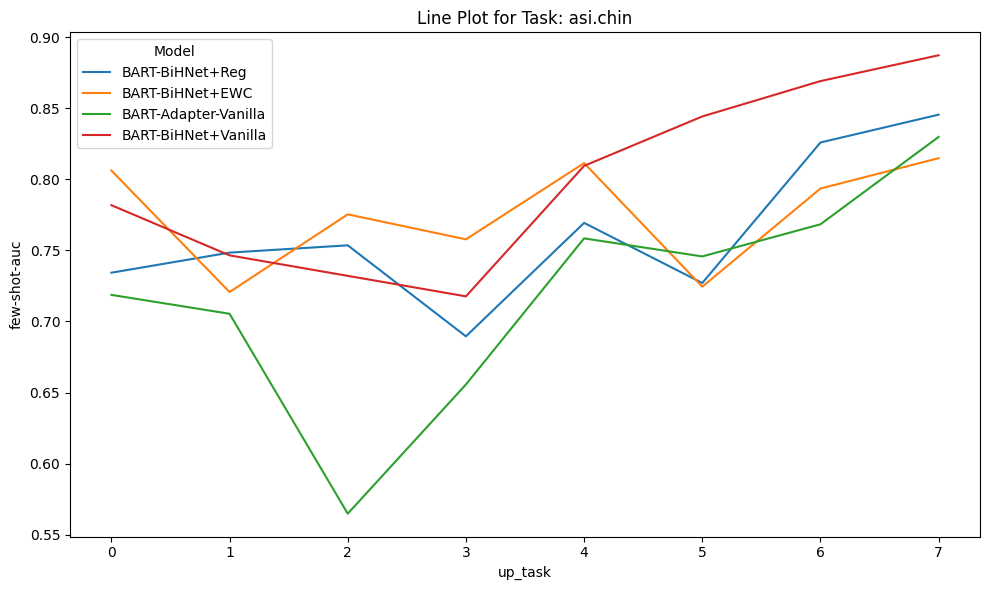

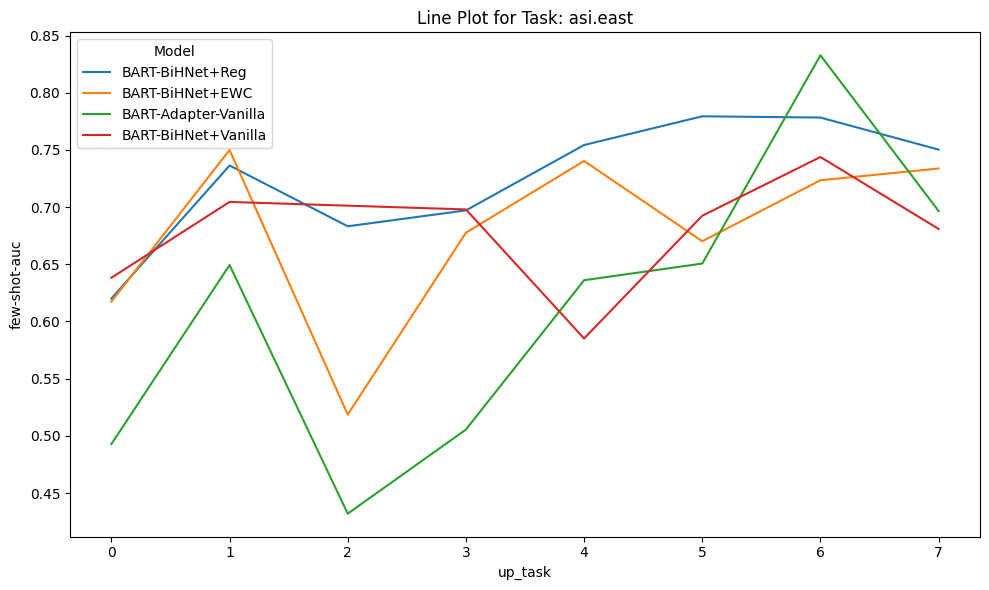

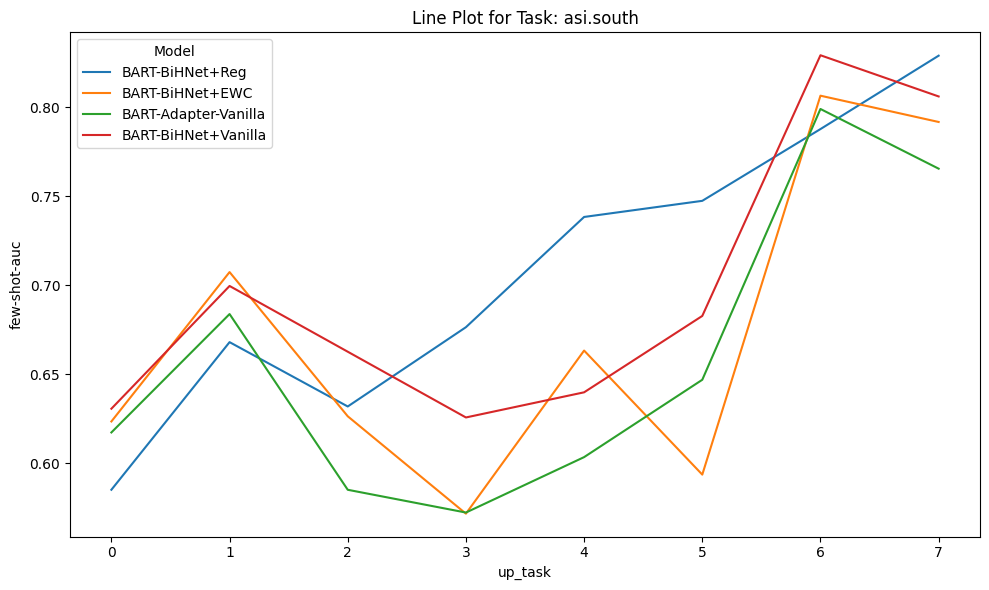

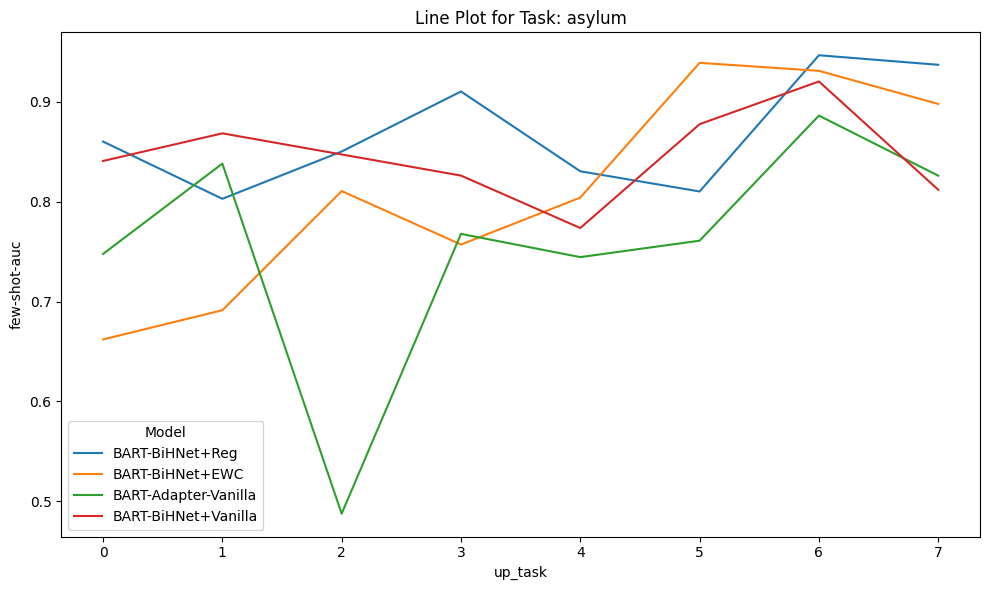

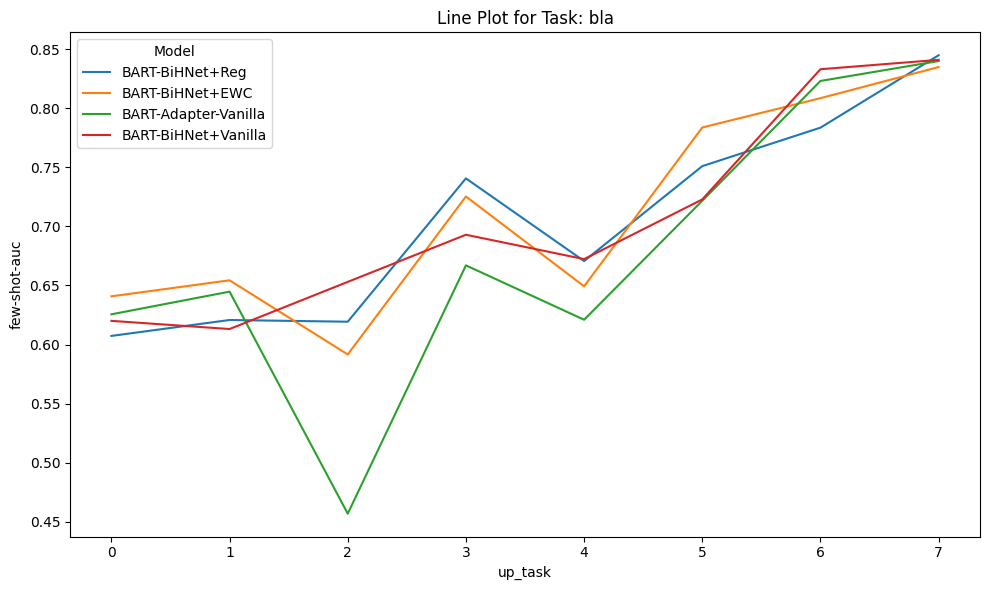

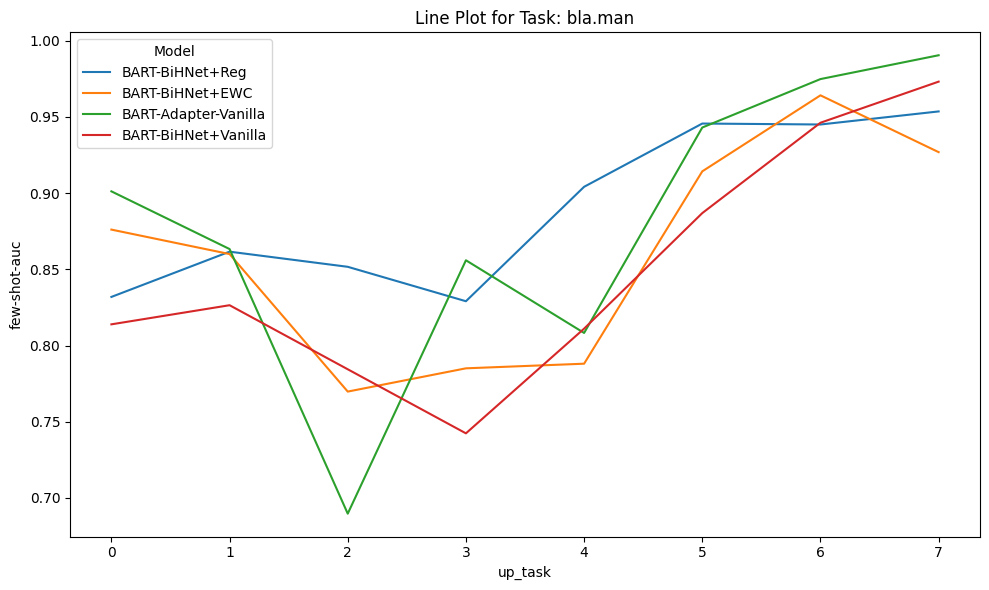

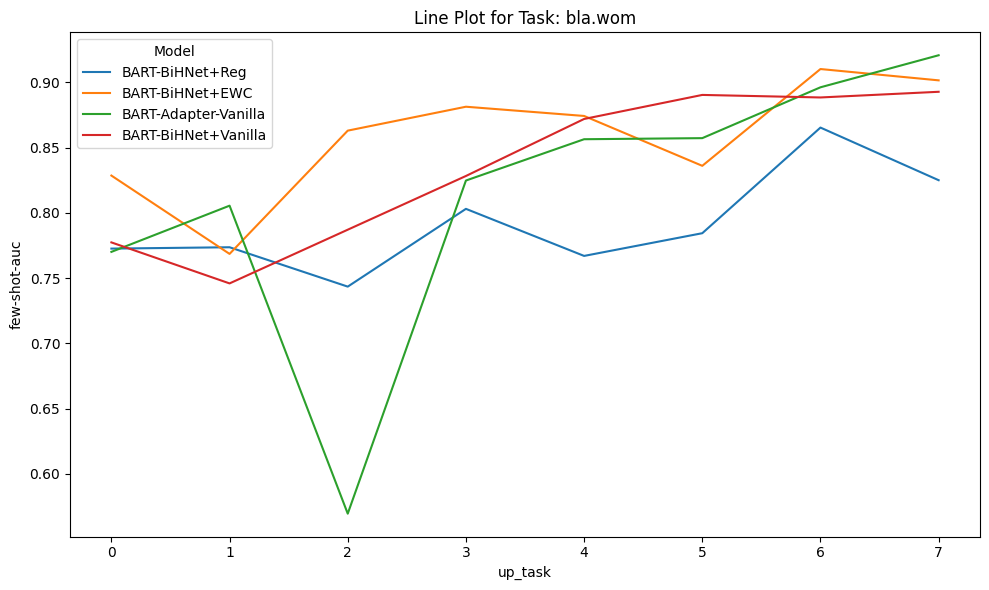

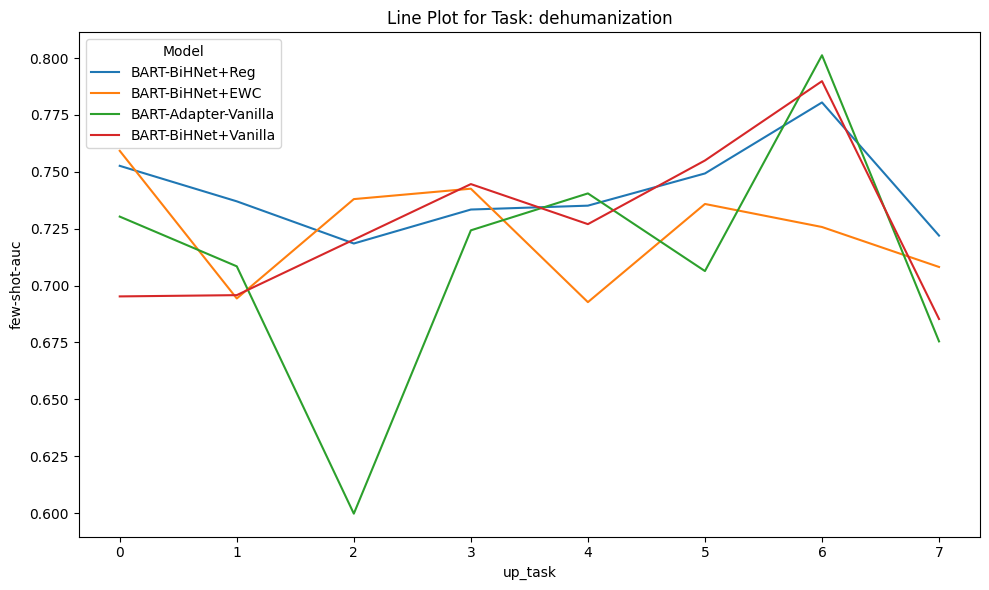

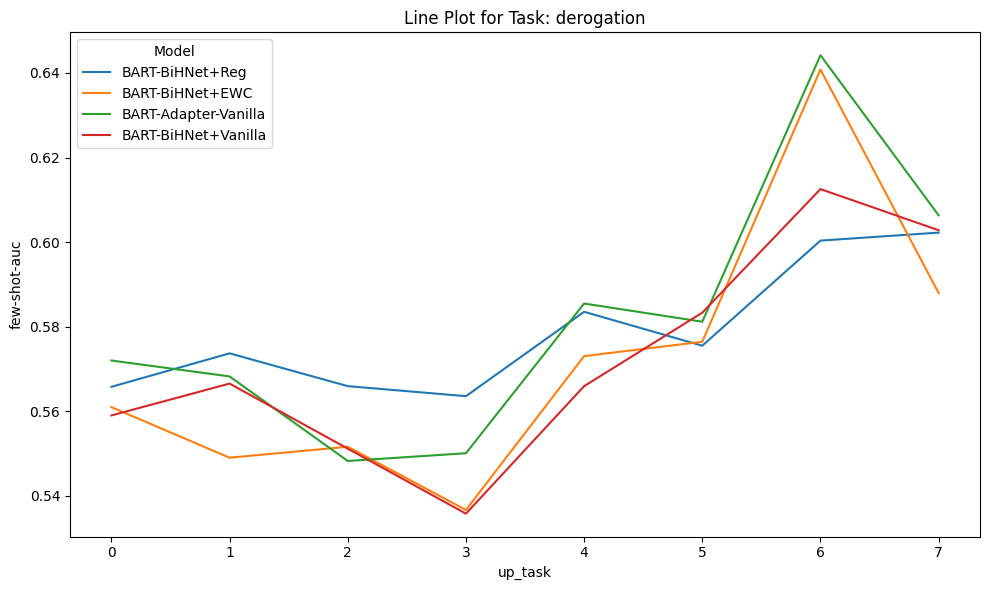

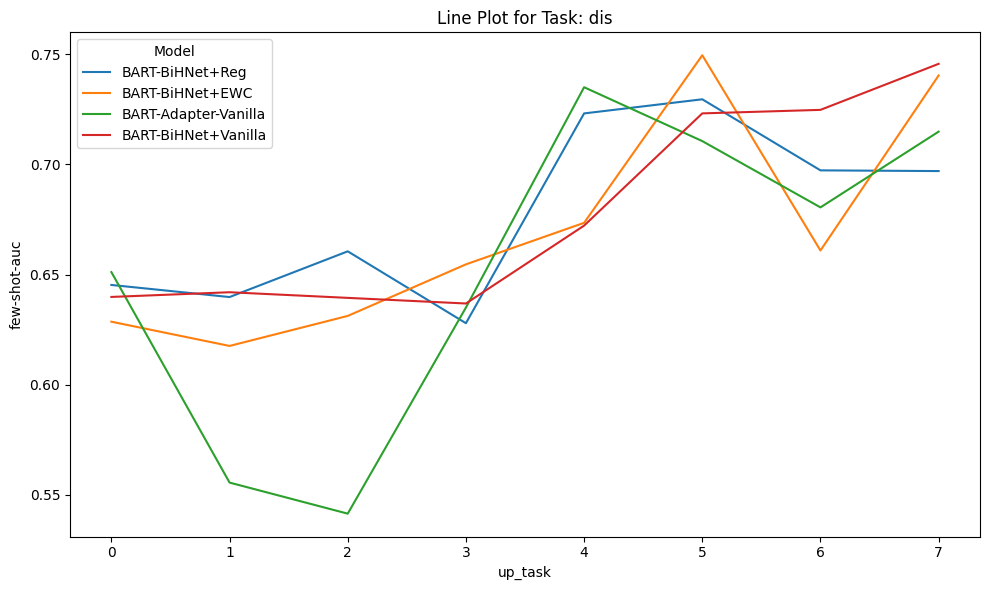

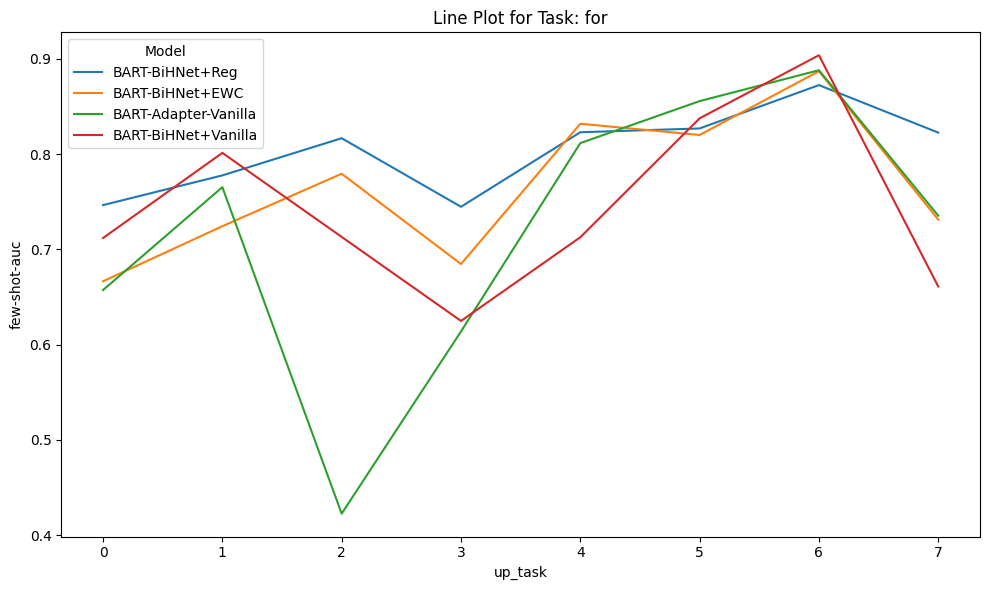

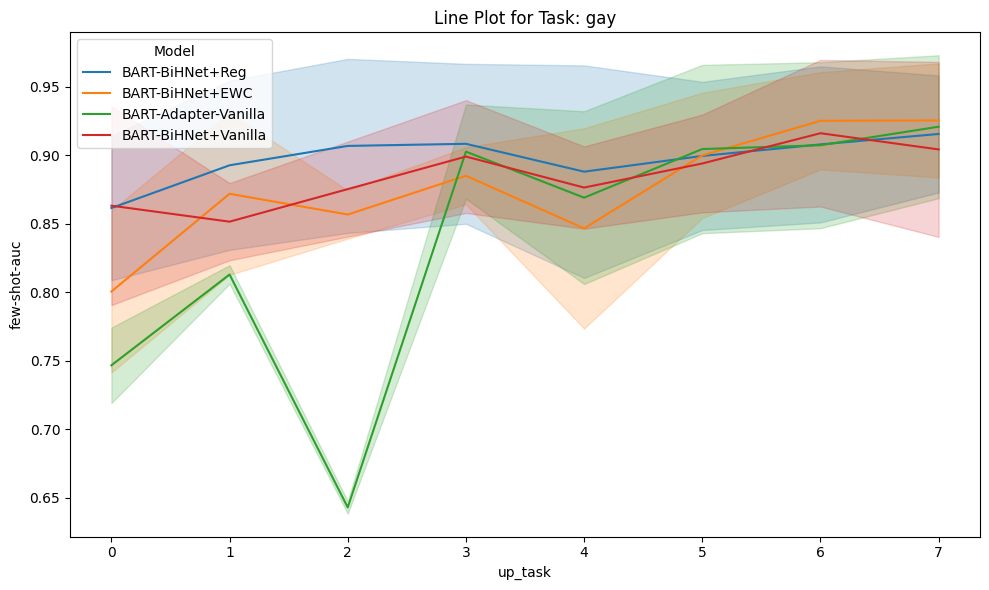

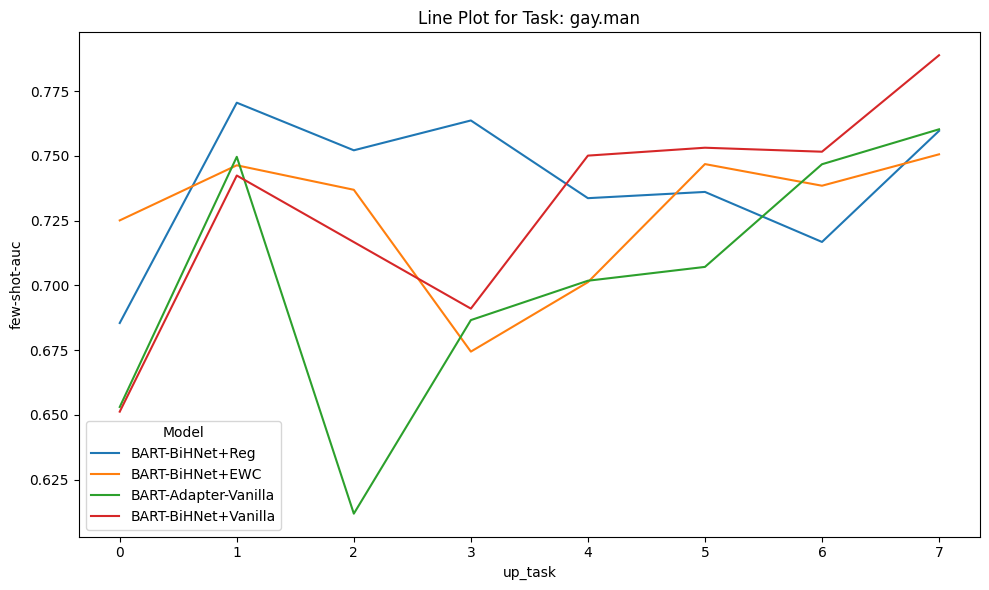

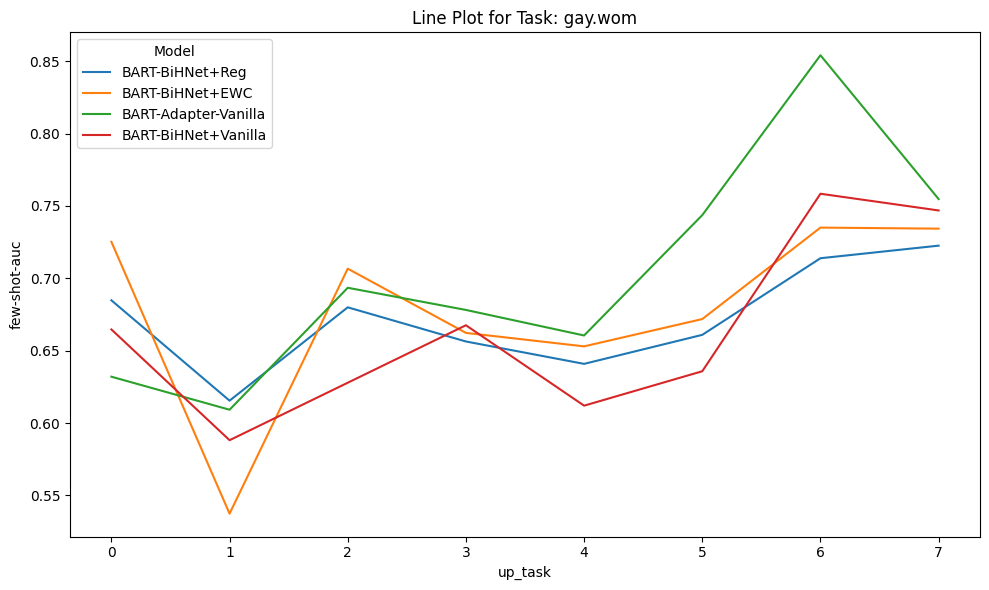

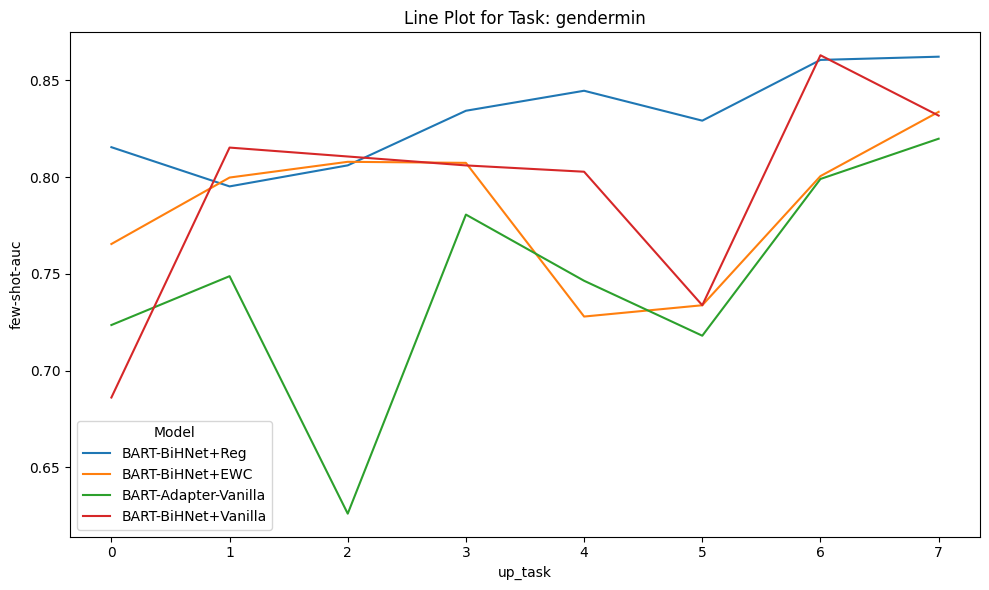

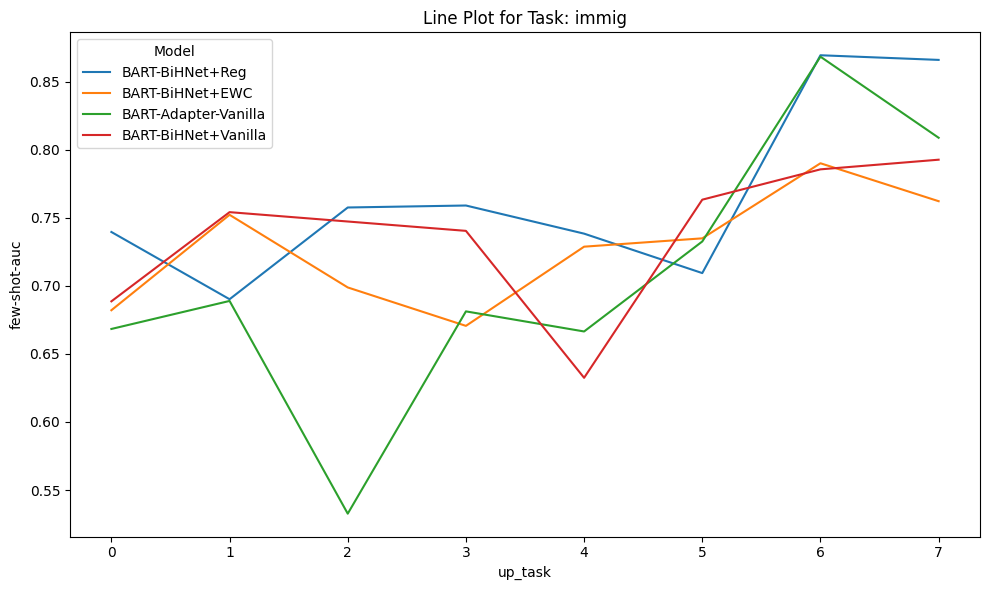

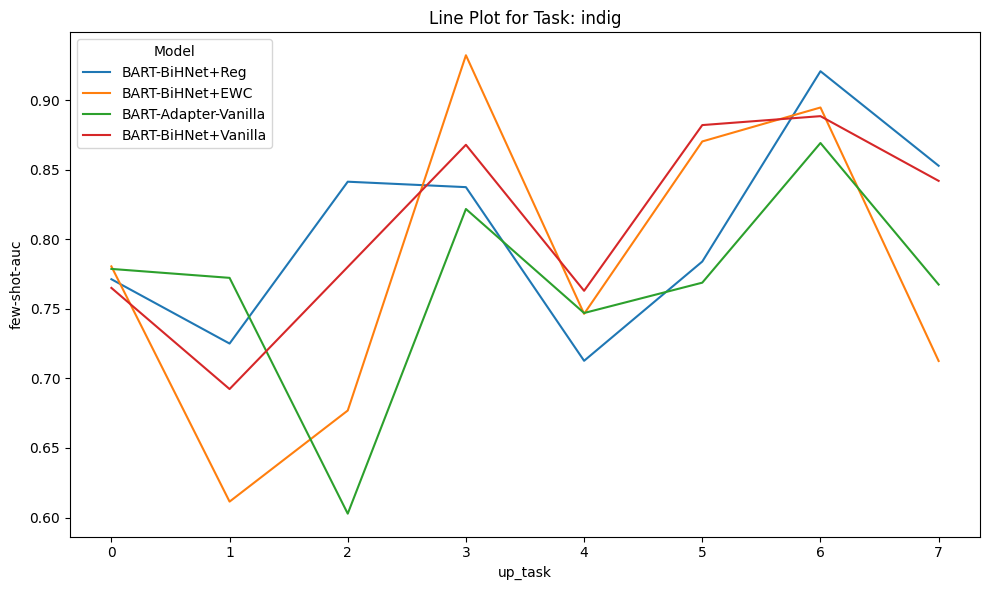

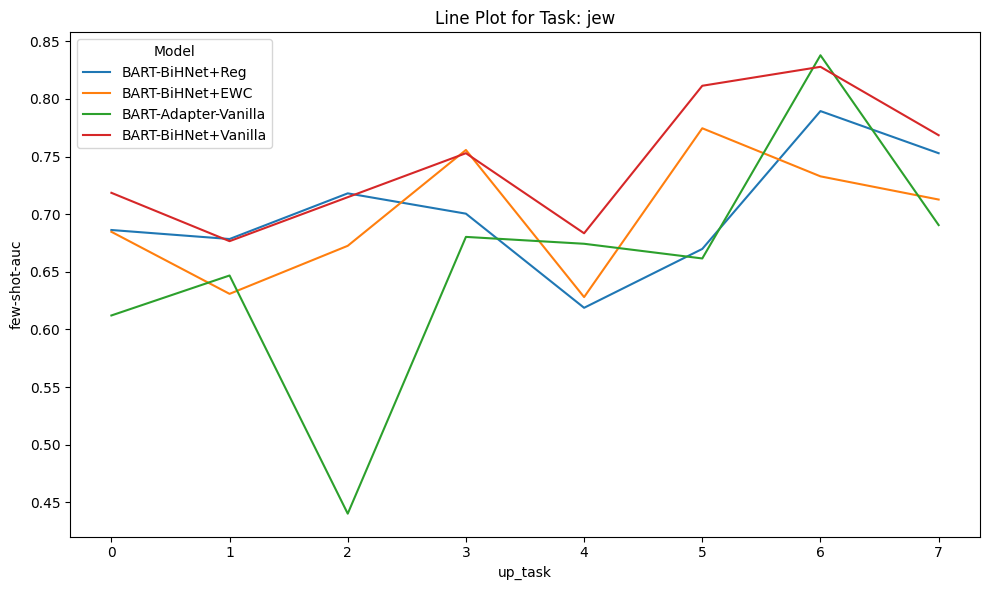

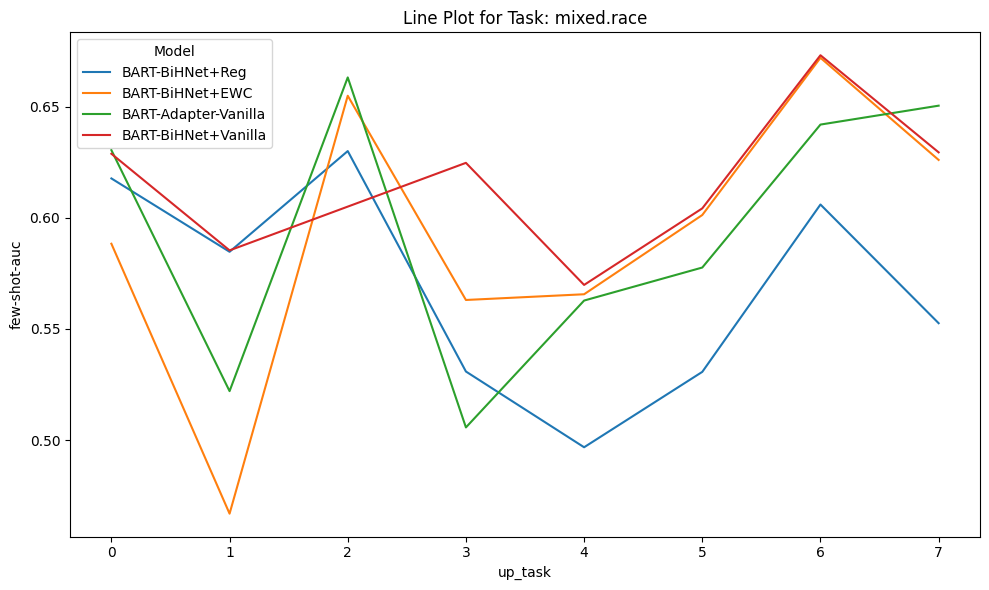

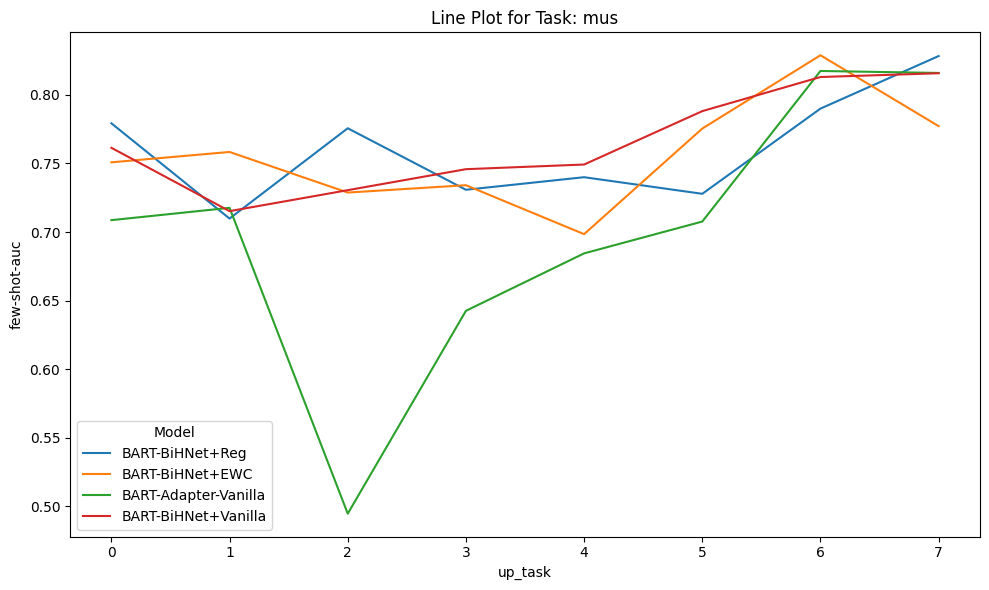

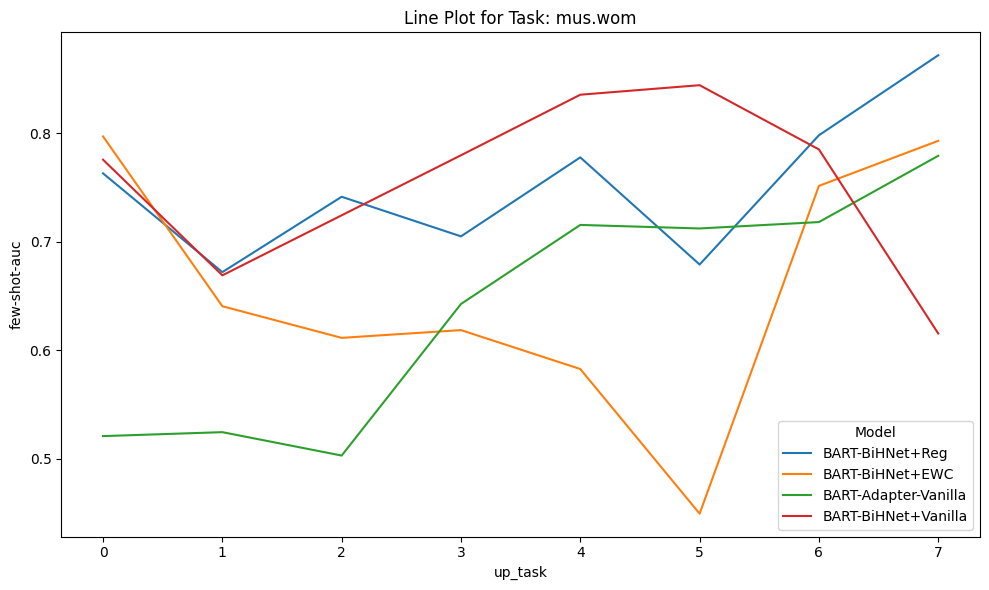

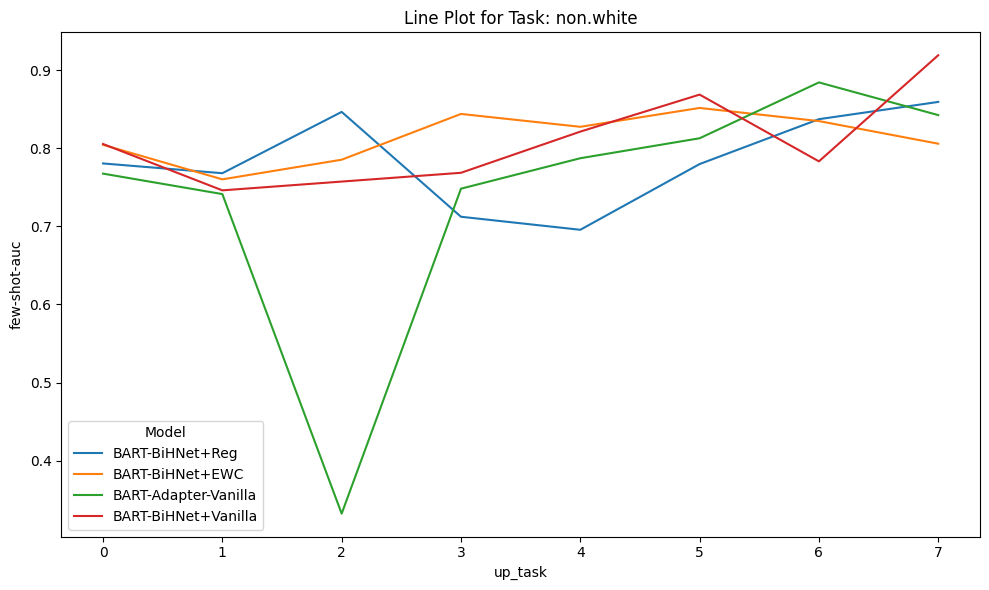

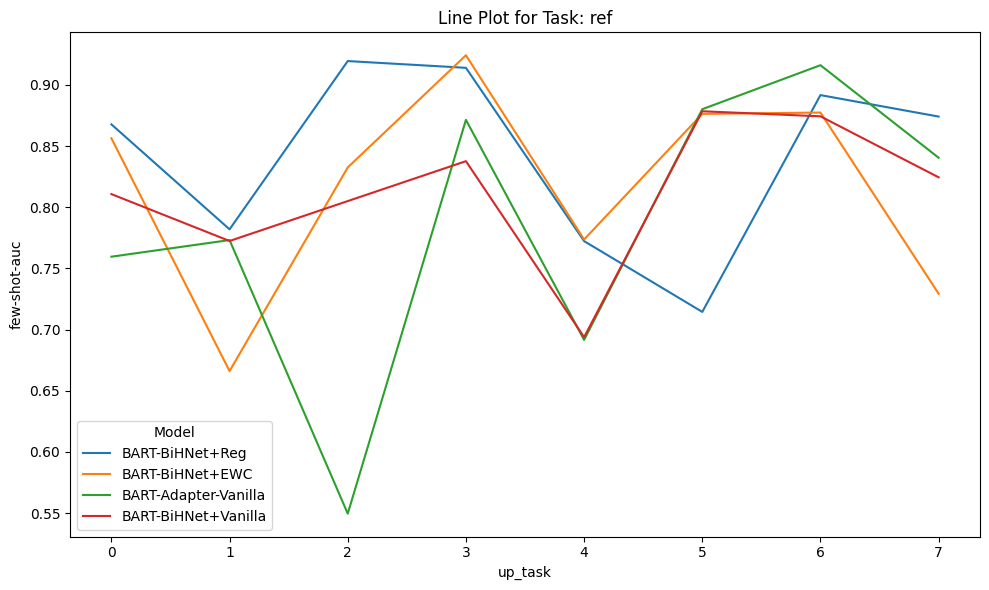

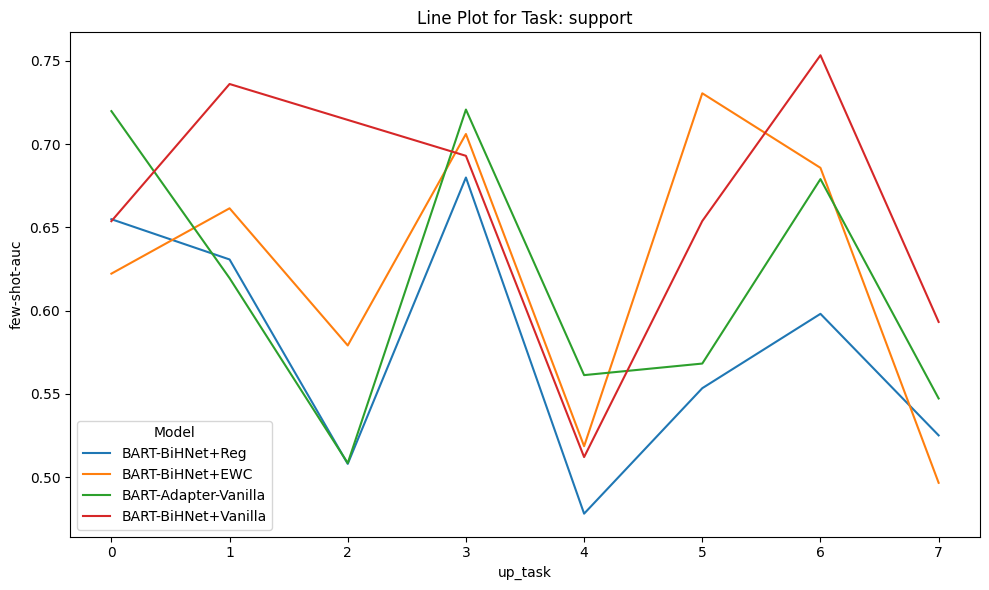

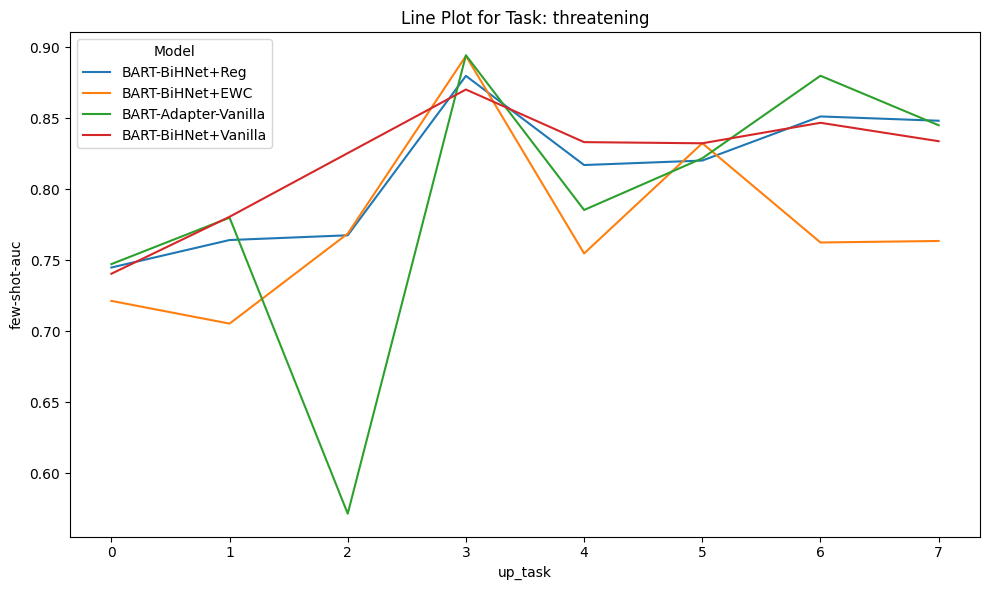

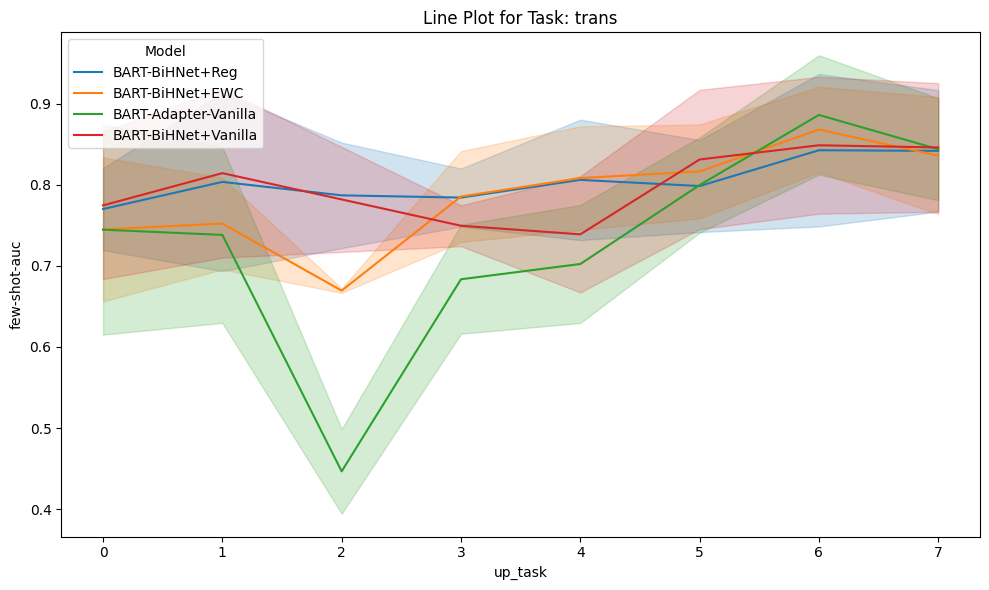

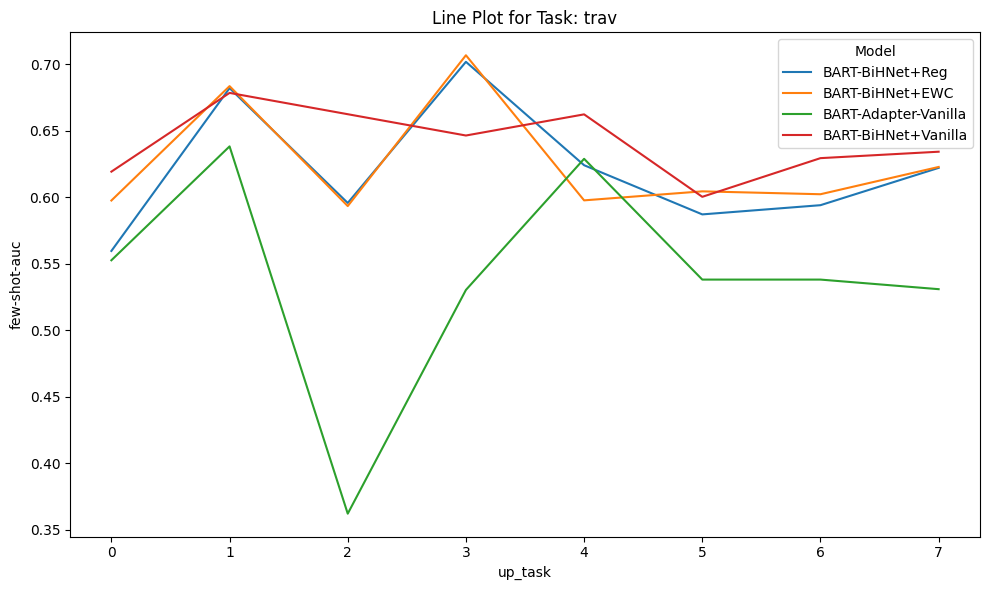

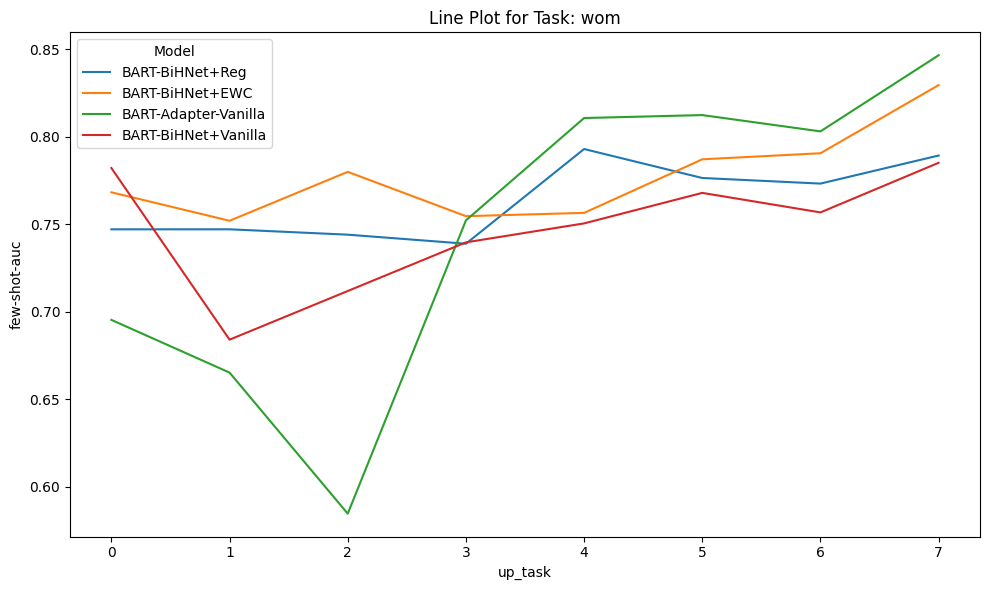

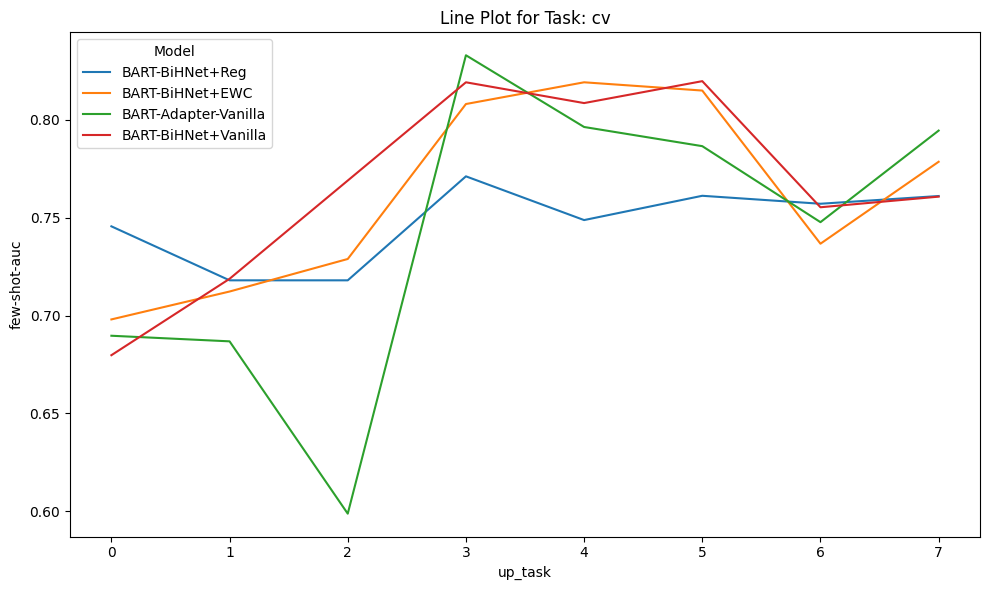

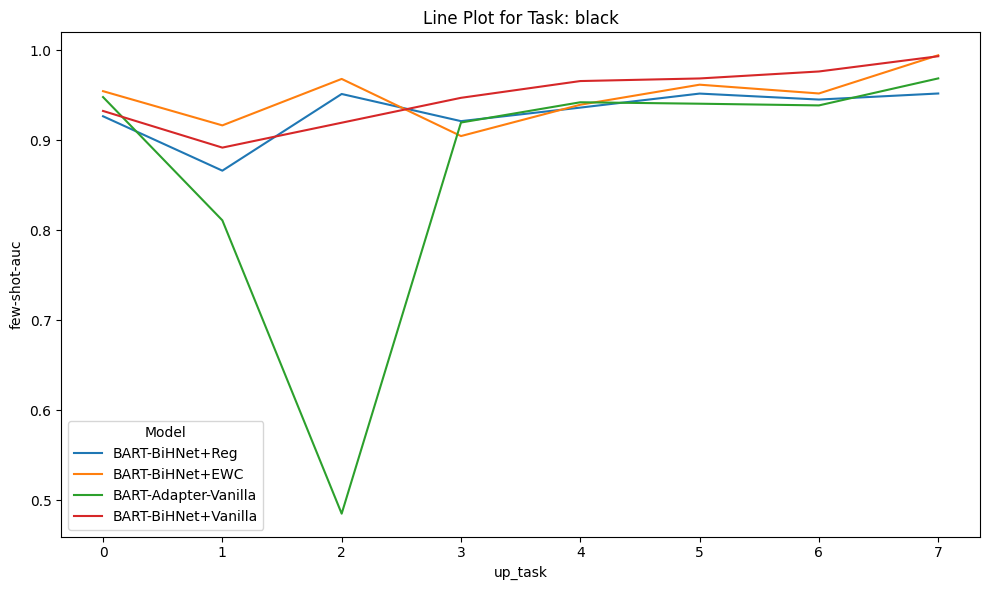

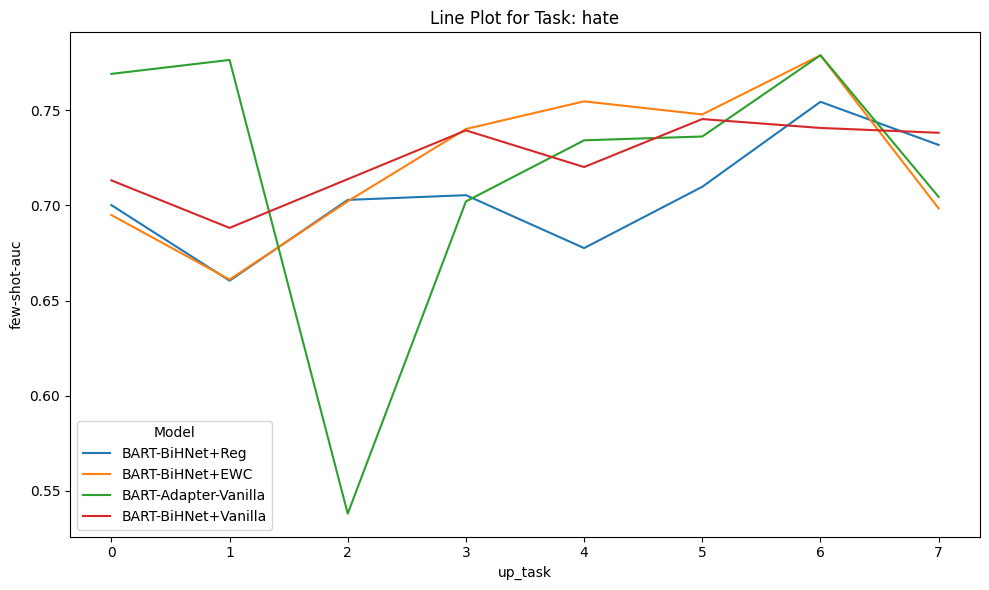

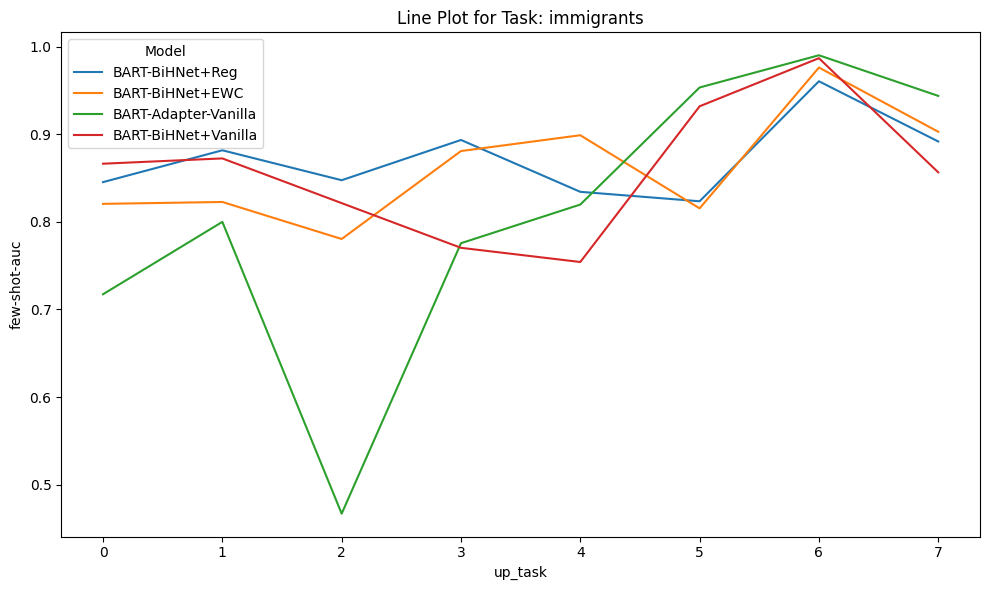

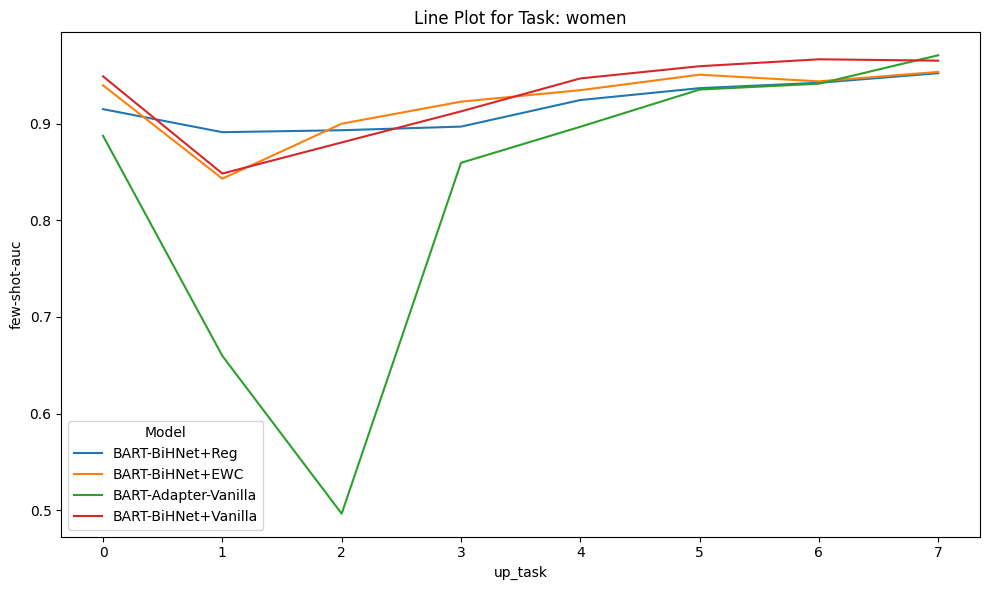

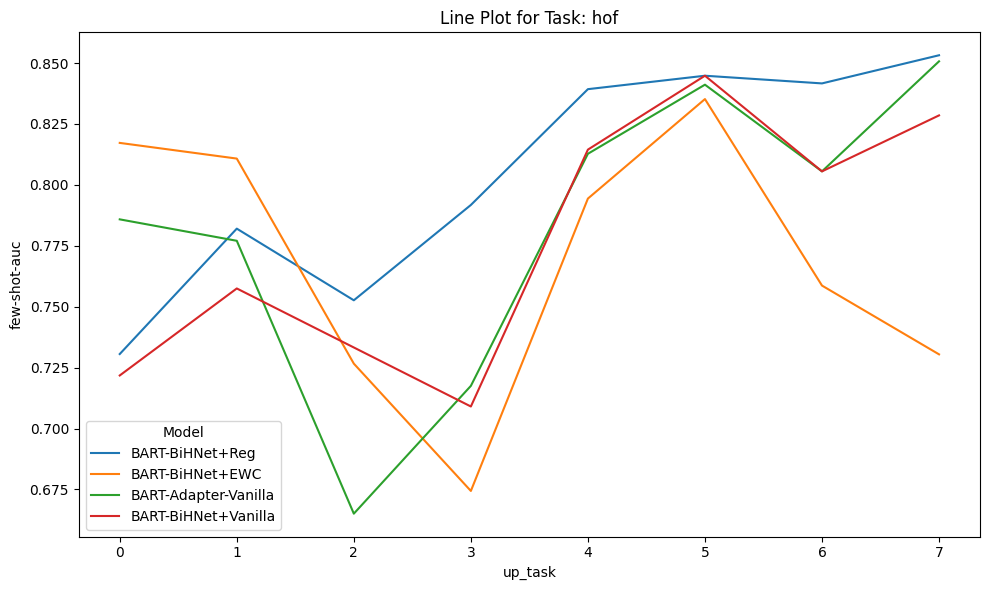

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


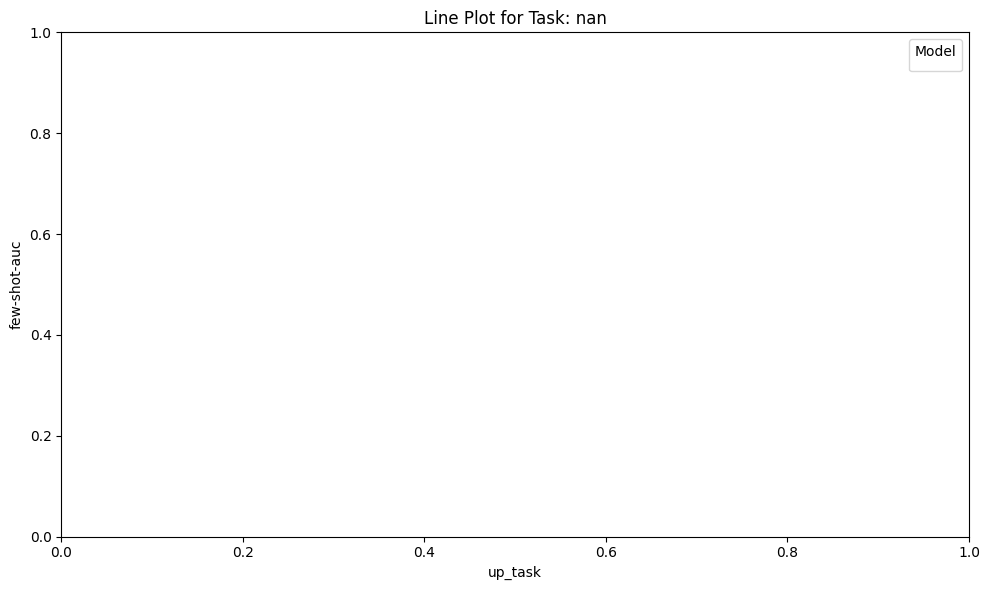

In [41]:
# Iterate through unique tasks and create separate line plots
unique_tasks = fs_on_upstream_df['task'].unique()

for task in unique_tasks:
    subset_df = fs_on_upstream_df[fs_on_upstream_df['task'] == task]
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.lineplot(data=subset_df, x="up_task", y="few-shot-auc", hue="model")
    plt.title(f'Line Plot for Task: {task}')
    plt.xlabel('up_task')
    plt.ylabel('few-shot-auc')
    plt.legend(title="Model", loc='best')
    plt.tight_layout()  # To ensure proper spacing between subplots
    plt.show()

<Axes: xlabel='up_task', ylabel='few-shot-auc'>

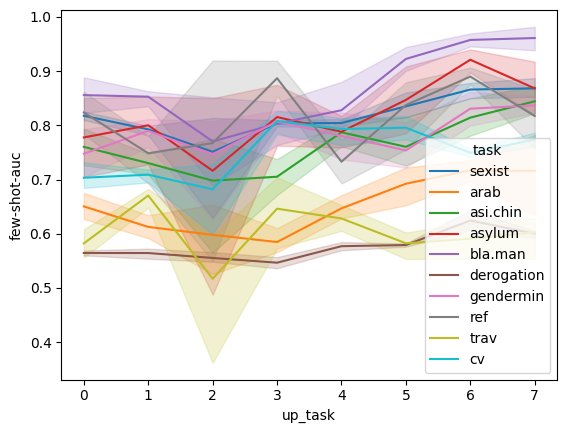

In [37]:
fs_on_upstream_df[fs_on_upstream_df.task =="sexist"]

import seaborn as sns
sns.lineplot(data=fs_on_upstream_df[fs_on_upstream_df.task.isin(tasks)]
, x = "up_task", y ="few-shot-auc", hue="task")

### Best model fewshot performance

In [11]:
def get_fs_df(dir_dict, metrics_type):
    dfs = []
    for alg in dir_dict:
        print(alg)
        for with_dash in [True, False]:
            df =  make_few_shot_result_table(dir_dict[alg], postfix="_naive_16shot", metrics_type=metrics_type, with_dash=with_dash)
            if df.empty:
                print("df", df)
                print(alg, with_dash, "hereeee")
                continue
            if "task_detail" in df.columns:
                df = pd.DataFrame(df.groupby(["task_name", "task_detail"])[metrics_type].max()).reset_index()
            else:
                df = pd.DataFrame(df.groupby(["task_name"])[metrics_type].max()).reset_index()
            df["alg"] = alg
            dfs.append(df)
    all_fs_df = pd.concat(dfs)
    all_fs_df = all_fs_df[[metrics_type, "task_name", "task_detail",  "alg"]]
    all_fs_df = all_fs_df.rename(columns={metrics_type: f'few-shot-{metrics_type}', 
                                                      'alg': 'model', 
                                                      'task_name': 'dataset', 
                                                      'task_detail': 'task'})
    return all_fs_df

In [14]:
dir_dict

{'BART-BiHNet+Reg': '../runs/BiHNet_Reg_shuffled_published_temporal_set_0.01_s64_d256_limit/1e-4/0/',
 'BART-BiHNet+EWC': '../runs/BiHNet_ewc_shuffled_published_temporal_set_0.01_s64_d256_limit/1e-4/0/',
 'BART-Adapter-Multitask': '../runs/adpter_mtl_shuffled_published_temporal_set_0.01_s64_d256_limit/1e-4/0/',
 'BART-BiHNet-Multitask': '../runs/mtl_hnet_shuffled_published_temporal_set_0.01_s64_d256_limit/1e-4/0/',
 'BART-Adapter-Vanilla': '../runs/adapter_vanilla_shuffled_published_temporal_set_0.01_s64_d256_limit/1e-4/0/',
 'BART-BiHNet+Vanilla': '../runs/BiHNet_vanilla_shuffled_published_temporal_set_0.01_s64_d256_limit/1e-4/0/'}

In [12]:
fs_auc_df = get_fs_df(dir_dict, metrics_type='auc')
fs_f1_df = get_fs_df(dir_dict, metrics_type='f1')

BART-BiHNet+Reg
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot.csv
BART-BiHNet+EWC
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot.csv
BART-Adapter-Multitask
df Empty DataFrame
Columns: []
Index: []
BART-Adapter-Multitask True hereeee
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot.csv
df Empty DataFrame
Columns: []
Index: []
BART-Adapter-Multitask False hereeee
BART-BiHNet-Multitask
df Empty DataFrame
Columns: []
Index: []
BART-BiHNet-Multitask True hereeee
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot.csv
df Empty DataFrame
Columns: []
Index: []
BART-BiHNet-Multitask False hereeee
BART-Adapter-Vanilla
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot.csv
BART-BiHNet+Vanilla
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot.csv
BART-BiHNet+Reg
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+)_fewshot_at_-1_naive_16shot.cs

In [13]:
fs_auc_df[fs_auc_df.model=="BART-Adapter-Vanilla"]

few-shot-auc             dataset            task                 model
0       0.653533                 cad   counterspeech  BART-Adapter-Vanilla
1       0.806424                cmsb          sexist  BART-Adapter-Vanilla
2       0.942469               conan        disabled  BART-Adapter-Vanilla
3       0.953201               conan            jews  BART-Adapter-Vanilla
4       0.888924               conan            lgbt  BART-Adapter-Vanilla
5       0.953692               conan         migrant  BART-Adapter-Vanilla
6       0.985618               conan         muslims  BART-Adapter-Vanilla
7       0.894808               conan             poc  BART-Adapter-Vanilla
8       0.958316               conan           woman  BART-Adapter-Vanilla
9       0.756703               dygen         african  BART-Adapter-Vanilla
10      0.573715               dygen       animosity  BART-Adapter-Vanilla
11      0.619082               dygen            arab  BART-Adapter-Vanilla
12      0.674231               dygen             asi  BART-Adapter-Vanilla
13      0.788412               dygen        asi.chin  BART-Adapter-Vanilla
14      0.649637               dygen        asi.east  BART-Adapter-Vanilla
15      0.657302               dygen       asi.south  BART-Adapter-Vanilla
16      0.848841               dygen          asylum  BART-Adapter-Vanilla
17      0.701316               dygen             bla  BART-Adapter-Vanilla
18      0.843789               dygen         bla.man  BART-Adapter-Vanilla
19      0.665484               dygen         bla.wom  BART-Adapter-Vanilla
20      0.758882               dygen  dehumanization  BART-Adapter-Vanilla
21      0.592919               dygen      derogation  BART-Adapter-Vanilla
22      0.610532               dygen             dis  BART-Adapter-Vanilla
23      0.731039               dygen             for  BART-Adapter-Vanilla
24      0.663810               dygen             gay  BART-Adapter-Vanilla
25      0.704786               dygen         gay.man  BART-Adapter-Vanilla
26      0.589463               dygen         gay.wom  BART-Adapter-Vanilla
27      0.638366               dygen       gendermin  BART-Adapter-Vanilla
28      0.736724               dygen           immig  BART-Adapter-Vanilla
29      0.656889               dygen           indig  BART-Adapter-Vanilla
30      0.672116               dygen             jew  BART-Adapter-Vanilla
31      0.597240               dygen      mixed.race  BART-Adapter-Vanilla
32      0.781403               dygen             mus  BART-Adapter-Vanilla
33      0.491536               dygen         mus.wom  BART-Adapter-Vanilla
34      0.818931               dygen       non.white  BART-Adapter-Vanilla
35      0.768359               dygen             ref  BART-Adapter-Vanilla
36      0.551508               dygen         support  BART-Adapter-Vanilla
37      0.693301               dygen     threatening  BART-Adapter-Vanilla
38      0.667974               dygen           trans  BART-Adapter-Vanilla
39      0.514560               dygen            trav  BART-Adapter-Vanilla
40      0.783228               dygen             wom  BART-Adapter-Vanilla
41      0.797053                 ghc              cv  BART-Adapter-Vanilla
42      0.972372           hatecheck           black  BART-Adapter-Vanilla
43      0.982123           hatecheck        disabled  BART-Adapter-Vanilla
44      0.774628           hatecheck             gay  BART-Adapter-Vanilla
45      0.722360           hatecheck            hate  BART-Adapter-Vanilla
46      0.975703           hatecheck      immigrants  BART-Adapter-Vanilla
47      0.919003           hatecheck         muslims  BART-Adapter-Vanilla
48      0.890440           hatecheck           trans  BART-Adapter-Vanilla
49      0.936615           hatecheck           women  BART-Adapter-Vanilla
50      0.764443         us_election             hof  BART-Adapter-Vanilla
0       0.631539                BAD2             NaN  BART-Adapter-Vanilla
1       0.615178             

In [15]:
fs_df = fs_f1_df.merge(fs_auc_df, on=['model', 'dataset', 'task'])

In [16]:
fs_df = fs_df.fillna("-")

In [18]:
fs_df.groupby("model")['few-shot-f1'].mean()

model
BART-Adapter-Vanilla    0.268798
BART-BiHNet+EWC         0.269111
BART-BiHNet+Reg         0.268573
BART-BiHNet+Vanilla     0.272571
Name: few-shot-f1, dtype: float64

In [18]:
fs_df.groupby("model")['few-shot-f1'].mean()

model
BART-Adapter-Multitask    0.288102
BART-Adapter-Vanilla      0.256353
BART-BiHNet+EWC           0.257523
BART-BiHNet+Reg           0.298919
BART-BiHNet+Vanilla       0.270319
BART-BiHNet-Multitask     0.257100
Name: few-shot-f1, dtype: float64

In [19]:
fs_df.groupby("model")['few-shot-auc'].mean()

model
BART-Adapter-Vanilla    0.756767
BART-BiHNet+EWC         0.770214
BART-BiHNet+Reg         0.804270
BART-BiHNet+Vanilla     0.786536
Name: few-shot-auc, dtype: float64

In [19]:
fs_df.groupby("model")['few-shot-auc'].mean()

model
BART-Adapter-Multitask    0.816277
BART-Adapter-Vanilla      0.764620
BART-BiHNet+EWC           0.765808
BART-BiHNet+Reg           0.818512
BART-BiHNet+Vanilla       0.771721
BART-BiHNet-Multitask     0.795745
Name: few-shot-auc, dtype: float64

In [20]:
fs_df['model_order'] = fs_df['model'].replace(model_mapping)


In [21]:
fs_df = fs_df.sort_values(['dataset','task', 'model_order'])

In [22]:
fs_df = fs_df[['dataset', 'task', 'model', 'few-shot-auc', 'few-shot-f1']]

## Latex Few shot

In [23]:
latex_table = fs_df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lllrr}
\toprule
dataset & task & model & few-shot-auc & few-shot-f1 \\
\midrule
BAD2 & - & BART-Adapter-Vanilla & 0.626491 & 0.475584 \\
BAD2 & - & BART-BiHNet+Vanilla & 0.591835 & 0.442589 \\
BAD2 & - & BART-BiHNet+Reg & 0.627312 & 0.469799 \\
BAD2 & - & BART-BiHNet+EWC & 0.624396 & 0.483940 \\
BAD2 & - & BART-Adapter-Multitask & 0.643871 & 0.492441 \\
BAD2 & - & BART-BiHNet-Multitask & 0.661902 & 0.482916 \\
BAD4 & - & BART-Adapter-Vanilla & 0.590429 & 0.335484 \\
BAD4 & - & BART-BiHNet+Vanilla & 0.560764 & 0.404692 \\
BAD4 & - & BART-BiHNet+Reg & 0.591853 & 0.445521 \\
BAD4 & - & BART-BiHNet+EWC & 0.623405 & 0.448454 \\
BAD4 & - & BART-Adapter-Multitask & 0.628114 & 0.482385 \\
BAD4 & - & BART-BiHNet-Multitask & 0.637908 & 0.474747 \\
cad & counterspeech & BART-Adapter-Vanilla & 0.947467 & 0.004090 \\
cad & counterspeech & BART-BiHNet+Vanilla & 0.940275 & 0.004717 \\
cad & counterspeech & BART-BiHNet+Reg & 0.994684 & 0.003210 \\
cad & counterspeech & BART-BiHNet+EWC 

# Final Accuracy

In [20]:
dir_dict = {"BART-BiHNet+Reg":f"../runs/BiHNet_Reg_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+EWC":f"../runs/BiHNet_ewc_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-Adapter-Multitask": f"../runs/adpter_mtl_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet-Multitask": f"../runs/mtl_hnet_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-Adapter-Vanilla": f"../runs/adapter_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+Vanilla": f"../runs/BiHNet_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
           }

In [26]:
dir_dict = {"BART-BiHNet+Reg":f"../runs/BiHNet_Reg_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+EWC":f"../runs/BiHNet_ewc_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-Adapter-Vanilla": f"../runs/adapter_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
            "BART-BiHNet+Vanilla": f"../runs/BiHNet_vanilla_{set_name}_0.01_s64_d256_limit/1e-4/0/",
           }

In [27]:
def get_final_df(dir_dict, metrics_type):
    dfs = []
    for alg in dir_dict:
        if alg =="pretrained" :
            continue
        print(alg)
        df1 =  make_results_table(dir_dict[alg], metrics_type=metrics_type, with_dash=True)
        df2 =  make_results_table(dir_dict[alg], metrics_type=metrics_type, with_dash=False)
        df = pd.concat([df1, df2])
        df['task_id'] = df['task_id'].astype(int)
        df['at_task'] = df['at_task'].astype(int)
        df['step'] = df['step'].astype(int)
        df = df[df.at_task == max(df.at_task)]
        if "task_detail" in  df.columns:
            idx = df.groupby(["task_name", "task_detail"])["step"].transform(max) == df["step"]
        else:
            print("here")
            idx = df.groupby(["task_name"])["step"].transform(max) == df["step"]

        df = df[idx]                      
        df["alg"] = alg
        dfs.append(df)
    all_final_df = pd.concat(dfs)
    all_final_df = all_final_df[[metrics_type, "task_name", "task_detail",  "alg"]]
    all_final_df = all_final_df.rename(columns={metrics_type: f'final-{metrics_type}', 
                                                      'alg': 'model', 
                                                      'task_name': 'dataset', 
                                                      'task_detail': 'task'})
    return all_final_df

In [28]:
final_auc_df = get_final_df(dir_dict, metrics_type='auc')
final_f1_df = get_final_df(dir_dict, metrics_type='f1')

BART-BiHNet+Reg
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-BiHNet+EWC
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-Adapter-Vanilla
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-BiHNet+Vanilla
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-BiHNet

In [29]:
final_df = final_auc_df.merge(final_f1_df, on=['model', 'dataset', 'task'])

In [30]:
final_df

final-auc          dataset                      task  \
0     0.955812  personal_attack                        ra   
1     0.913535  personal_attack                       tpa   
2     0.875877              ghc                        vo   
3     0.834489              ghc                        hd   
4     0.761444              ucc            generalisation   
5     0.724285              ucc                   hostile   
6     0.577403              ucc                 sarcastic   
7     0.693328              ucc                antagonize   
8     0.612604              ucc             condescending   
9     0.760295              ucc     generalisation_unfair   
10    0.600857              ucc                dismissive   
11    0.654635              ucc                   healthy   
12    0.951367  personal_attack                         a   
13    0.720852            dygen                      hate   
14    0.718122              cad       persondirectedabuse   
15    0.764534              cad  affiliationdirectedabuse   
16    0.790563              cad     identitydirectedabuse   
17    0.852040             hate                   hateful   
18    0.977334             hate                 offensive   
19    0.846587           jigsaw                  toxicity   
20    0.831883           jigsaw                    insult   
21    0.854970           jigsaw                   obscene   
22    0.881642           jigsaw           identity_attack   
23    0.872803           jigsaw                    threat   
24    0.747522          abusive                   hateful   
25    0.928231          abusive                   abusive   
26    0.901797  personal_attack                        ra   
27    0.841270  personal_attack                       tpa   
28    0.832482              ghc                        vo   
29    0.713862              ghc                        hd   
30    0.631695              ucc            generalisation   
31    0.799132              ucc                   hostile   
32    0.590280              ucc                 sarcastic   
33    0.757607              ucc                antagonize   
34    0.655180              ucc             condescending   
35    0.640564              ucc     generalisation_unfair   
36    0.721139              ucc                dismissive   
37    0.649101              ucc                   healthy   
38    0.895092  personal_attack                         a   
39    0.473085            dygen                      hate   
40    0.762970              cad       persondirectedabuse   
41    0.707640              cad  affiliationdirectedabuse   
42    0.646268              cad     identitydirectedabuse   
43    0.807877             hate                   hateful   
44    0.968556             hate                 offensive   
45    0.843192           jigsaw                  toxicity   
46    0.873827           jigsaw                    insult   
47    0.883226           jigsaw                   obscene   
48    0.622501           jigsaw           identity_attack   
49    0.679410           jigsaw                    threat   
50    0.717224          abusive                   hateful   
51    0.918671          abusive                   abusive   
52    0.927814  personal_attack                        ra   
53    0.895681  personal_attack                       tpa   
54    0.854396              ghc                        vo   
55    0.749965              ghc                        hd   
56    0.646690              ucc            generalisation   
57    0.808688              ucc                   hostile   
58    0.546802              ucc                 sarcastic   
59    0.747799              ucc                antagonize   
60    0.633677              ucc             condescending   
61    0.658635              ucc     generalisation_unfair   
62    0.697215              ucc                dismissive   
63    0.676791              ucc                   healthy   
64    0.929830  personal_attack         

In [31]:
print("shuffled")
final_df.groupby("model")['final-f1'].mean()

shuffled


model
BART-Adapter-Vanilla    0.273377
BART-BiHNet+EWC         0.270043
BART-BiHNet+Reg         0.273995
BART-BiHNet+Vanilla     0.276571
Name: final-f1, dtype: float64

In [29]:
final_df.groupby("model")['final-f1'].mean()

model
BART-Adapter-Multitask    0.382802
BART-Adapter-Vanilla      0.130313
BART-BiHNet+EWC           0.074141
BART-BiHNet+Reg           0.271746
BART-BiHNet+Vanilla       0.098584
BART-BiHNet-Multitask     0.318443
Name: final-f1, dtype: float64

In [32]:
print("shuffled")
final_df.groupby("model")['final-auc'].mean()

shuffled


model
BART-Adapter-Vanilla    0.764753
BART-BiHNet+EWC         0.751294
BART-BiHNet+Reg         0.796270
BART-BiHNet+Vanilla     0.759363
Name: final-auc, dtype: float64

In [30]:
final_df.groupby("model")['final-auc'].mean()

model
BART-Adapter-Multitask    0.872739
BART-Adapter-Vanilla      0.517685
BART-BiHNet+EWC           0.676287
BART-BiHNet+Reg           0.791544
BART-BiHNet+Vanilla       0.617468
BART-BiHNet-Multitask     0.833905
Name: final-auc, dtype: float64

In [34]:
latex_table = final_df[["dataset", "task", "model", "final-auc", "final-f1"]].to_latex(index=False)
print(latex_table)

\begin{tabular}{lllrr}
\toprule
dataset & task & model & final-auc & final-f1 \\
\midrule
personal_attack & a & BART-BiHNet+Reg & 0.956610 & 0.743326 \\
personal_attack & tpa & BART-BiHNet+Reg & 0.884294 & 0.093847 \\
ghc & hd & BART-BiHNet+Reg & 0.839976 & 0.370881 \\
ghc & vo & BART-BiHNet+Reg & 0.850554 & 0.325468 \\
ucc & hostile & BART-BiHNet+Reg & 0.722313 & 0.103139 \\
ucc & generalisation_unfair & BART-BiHNet+Reg & 0.839903 & 0.140312 \\
ucc & dismissive & BART-BiHNet+Reg & 0.642689 & 0.103784 \\
ucc & antagonize & BART-BiHNet+Reg & 0.711969 & 0.154799 \\
ucc & condescending & BART-BiHNet+Reg & 0.631144 & 0.137736 \\
ucc & sarcastic & BART-BiHNet+Reg & 0.579365 & 0.102000 \\
ucc & healthy & BART-BiHNet+Reg & 0.665776 & 0.211990 \\
ucc & generalisation & BART-BiHNet+Reg & 0.835866 & 0.152809 \\
personal_attack & ra & BART-BiHNet+Reg & 0.965032 & 0.684231 \\
dygen & hate & BART-BiHNet+Reg & 0.667232 & 0.618577 \\
cad & persondirectedabuse & BART-BiHNet+Reg & 0.612836 & 0.084211 \

## Instant Accuracy

In [33]:
def get_instant_df(dir_dict, metrics_type):
    dfs = []
    for alg in dir_dict:
        if alg =="pretrained" or 'Multitask' in alg:
            continue
        print(alg)
        df1 =  make_results_table(dir_dict[alg], metrics_type=metrics_type, with_dash=True)
        df2 =  make_results_table(dir_dict[alg], metrics_type=metrics_type, with_dash=False)
        df = pd.concat([df1, df2])
        df['task_id'] = df['task_id'].astype(int)
        df['at_task'] = df['at_task'].astype(int)
        df['step'] = df['step'].astype(int)
        df = df[df.task_id == df.at_task]
        if "task_detail" in  df.columns:
            # if df.groupby(["task_name", "task_detail"])["em"].transform(max) == 0.0:
            #     print("here")
            #     idx = df.groupby(["task_name", "task_detail"])["em"].transform(max)
            idx = df.groupby(["task_name", "task_detail"])[metrics_type].transform(max) == df[metrics_type]
        else:
            print("here")
            idx = df.groupby(["task_name"])["em"].transform(max) == df["em"]

        df = df[idx]                      
        df["alg"] = alg
        dfs.append(df)
    all_instant_df = pd.concat(dfs)
    all_instant_df = all_instant_df[[metrics_type, "task_name", "task_detail",  "alg", "task_id"]]
    all_instant_df = all_instant_df.rename(columns={metrics_type: f'instant-{metrics_type}', 
                                                      'alg': 'model', 
                                                      'task_name': 'dataset', 
                                                      'task_detail': 'task',
                                                    "task_id": "order"
                                                   })
    return all_instant_df


In [34]:
instant_auc_df = get_instant_df(dir_dict, metrics_type='auc')
instant_f1_df = get_instant_df(dir_dict, metrics_type='f1')

BART-BiHNet+Reg
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-BiHNet+EWC
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-Adapter-Vanilla
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-BiHNet+Vanilla
results_task_(\d+)_(\w+)-(\w+)_task_(\d+)_step_([\d]+).csv
Index(['task_id', 'task_name', 'task_detail', 'at_task', 'step', 'path', 'auc',
       'maj'],
      dtype='object')
results_task_(\d+)_(\w+)_task_(\d+)_step_([\d]+).csv
BART-BiHNet

In [35]:
instant_df = instant_auc_df.merge(instant_f1_df, on=['model', 'dataset', 'task', 'order'])

In [36]:
print("shuffled")
instant_df.groupby("model")['instant-f1'].mean()

shuffled


model
BART-Adapter-Vanilla    0.403709
BART-BiHNet+EWC         0.400269
BART-BiHNet+Reg         0.396531
BART-BiHNet+Vanilla     0.409259
Name: instant-f1, dtype: float64

In [38]:
instant_df.groupby("model")['instant-f1'].mean()

model
BART-Adapter-Vanilla    0.402099
BART-BiHNet+EWC         0.403327
BART-BiHNet+Reg         0.399602
BART-BiHNet+Vanilla     0.412636
Name: instant-f1, dtype: float64

In [37]:
print("shuffled")
instant_df.groupby("model")['instant-auc'].mean()

shuffled


model
BART-Adapter-Vanilla    0.884386
BART-BiHNet+EWC         0.878256
BART-BiHNet+Reg         0.882993
BART-BiHNet+Vanilla     0.881459
Name: instant-auc, dtype: float64

In [39]:
instant_df.groupby("model")['instant-auc'].mean()

model
BART-Adapter-Vanilla    0.882196
BART-BiHNet+EWC         0.880995
BART-BiHNet+Reg         0.881692
BART-BiHNet+Vanilla     0.878479
Name: instant-auc, dtype: float64

# combine two tables

In [40]:
final_instant_df = final_df.merge(instant_df, on=['model', 'dataset', 'task'], how='left')


In [41]:
final_instant_df['model_order'] = final_instant_df['model'].replace(model_mapping)
final_instant_df = final_instant_df.sort_values(['order', 'model_order'])


In [42]:
final_instant_df = final_instant_df[['order', 'dataset', 'task', 'model', 'final-f1', 'instant-f1', 'final-auc', 'instant-auc']]

# Latex

In [44]:
latex_table =final_instant_df.fillna("-").to_latex(index=False)
print(latex_table)

\begin{tabular}{llllrlrl}
\toprule
order & dataset & task & model & final-f1 & instant-f1 & final-auc & instant-auc \\
\midrule
0.000000 & personal_attack & a & BART-Adapter-Vanilla & 0.305006 & 0.750957 & 0.540933 & 0.962732 \\
0.000000 & personal_attack & a & BART-BiHNet+Vanilla & 0.265491 & 0.749760 & 0.727950 & 0.957005 \\
0.000000 & personal_attack & a & BART-BiHNet+Reg & 0.743326 & 0.751853 & 0.956610 & 0.959739 \\
0.000000 & personal_attack & a & BART-BiHNet+EWC & 0.295845 & 0.737895 & 0.896827 & 0.954632 \\
1.000000 & personal_attack & tpa & BART-Adapter-Vanilla & 0.062567 & 0.321267 & 0.461003 & 0.948346 \\
1.000000 & personal_attack & tpa & BART-BiHNet+Vanilla & 0.061224 & 0.296041 & 0.639220 & 0.938166 \\
1.000000 & personal_attack & tpa & BART-BiHNet+Reg & 0.093847 & 0.224464 & 0.884294 & 0.929268 \\
1.000000 & personal_attack & tpa & BART-BiHNet+EWC & 0.051033 & 0.275862 & 0.826217 & 0.924251 \\
2.000000 & personal_attack & ra & BART-Adapter-Vanilla & 0.360275 & 0.722284 &